In [7]:
import numpy as np

from IPython.display import display
from PIL import Image
from peewee import IntegerField, Model, CharField, SqliteDatabase, AutoField
import matplotlib.pyplot as plt

db = SqliteDatabase('events.db')


class Events(Model):
    id = AutoField()
    time = IntegerField()
    agent = CharField()
    event = CharField()
    participant_id = IntegerField()
    old_value = CharField(null=True)
    new_value = CharField(null=True)
    screenshot_file = CharField(null=True)

    class Meta:
        database = db

def show_screenshot_for_record(_id):
    events = Events.select().where(Events.id == _id).order_by(Events.time.asc()).limit(1)
    if len(events) == 0:
        print("No events found for id: ", _id)
        return
    event = events[0]
    image_path = event.screenshot_file
    print(_id)
    display(Image.open(image_path))


1612 1702981228421 USER OPEN_BOOK 4 None Under the Tuscan Sun -  screenshots/dfa67733-cbd8-41a2-97fc-785ad6f9c271.png
1613 1702981237709 USER NEXT_PAGE 4 None None screenshots/7d7d6236-1251-4af1-9df0-7e8787697fbf.png
1614 1702981285368 USER NEXT_PAGE 4 None None screenshots/4511e969-4de8-4e83-878a-f2595bb3ed56.png
1615 1702981342271 USER NEXT_PAGE 4 None None screenshots/28a77808-a848-4c43-818d-e4949f7dcced.png
1616 1702981366768 USER NEXT_PAGE 4 None None screenshots/6239b1c0-7515-45ca-9ea1-cb8eb0aafdb6.png
1618 1702981430395 USER OPEN_BOOK 4 None Chasing Sunsets -  screenshots/9c19c4e9-df7b-4c35-9ca8-7cf50bddbd55.png
1619 1702981433019 USER NEXT_PAGE 4 None None screenshots/b362b9e5-4ad1-4f76-b451-029e42c506d4.png
1620 1702981473348 USER NEXT_PAGE 4 None None screenshots/225478ef-c433-4e96-9d0b-aefc334fb3ce.png
1621 1702981532164 USER NEXT_PAGE 4 None None screenshots/163a59e2-1978-4e2f-8f5b-3aa7468c804e.png
1622 1702981543715 USER NEXT_PAGE 4 None None screenshots/24f2daa8-d5e7-4a88

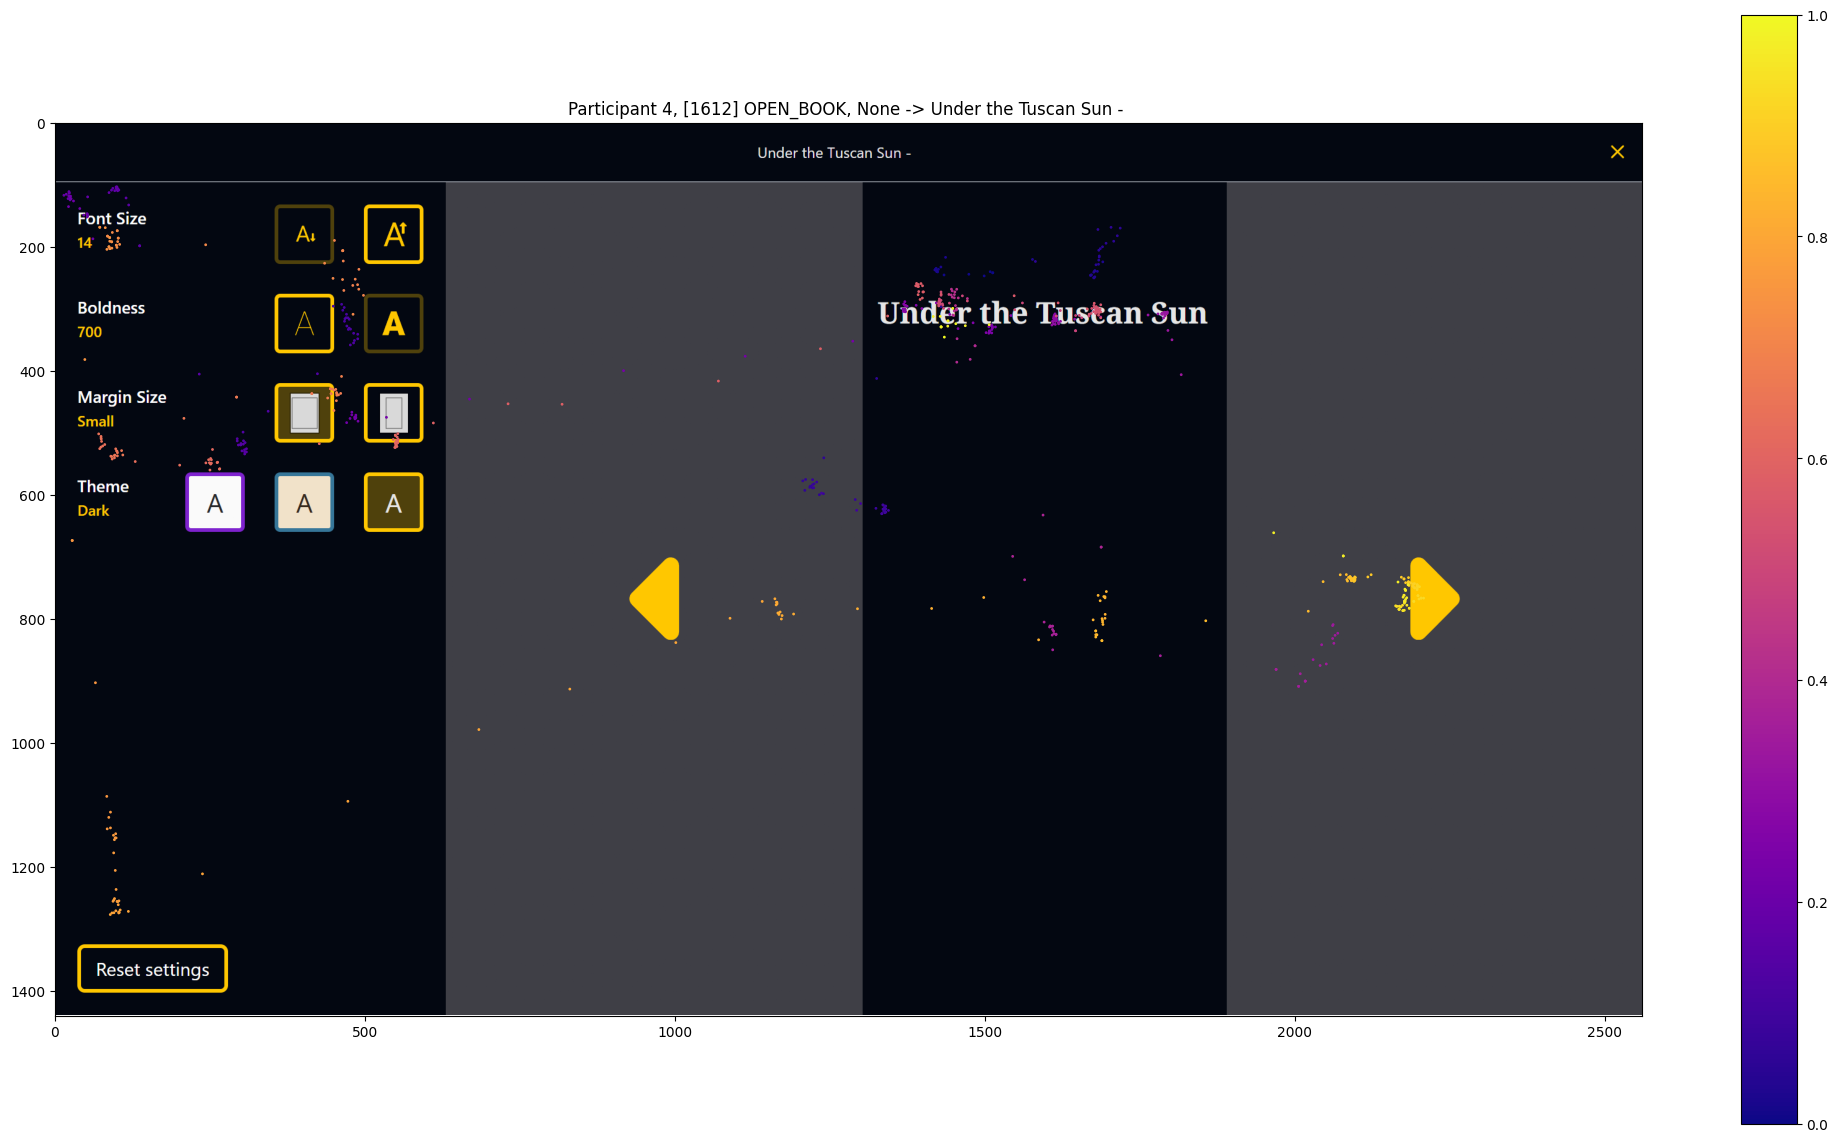

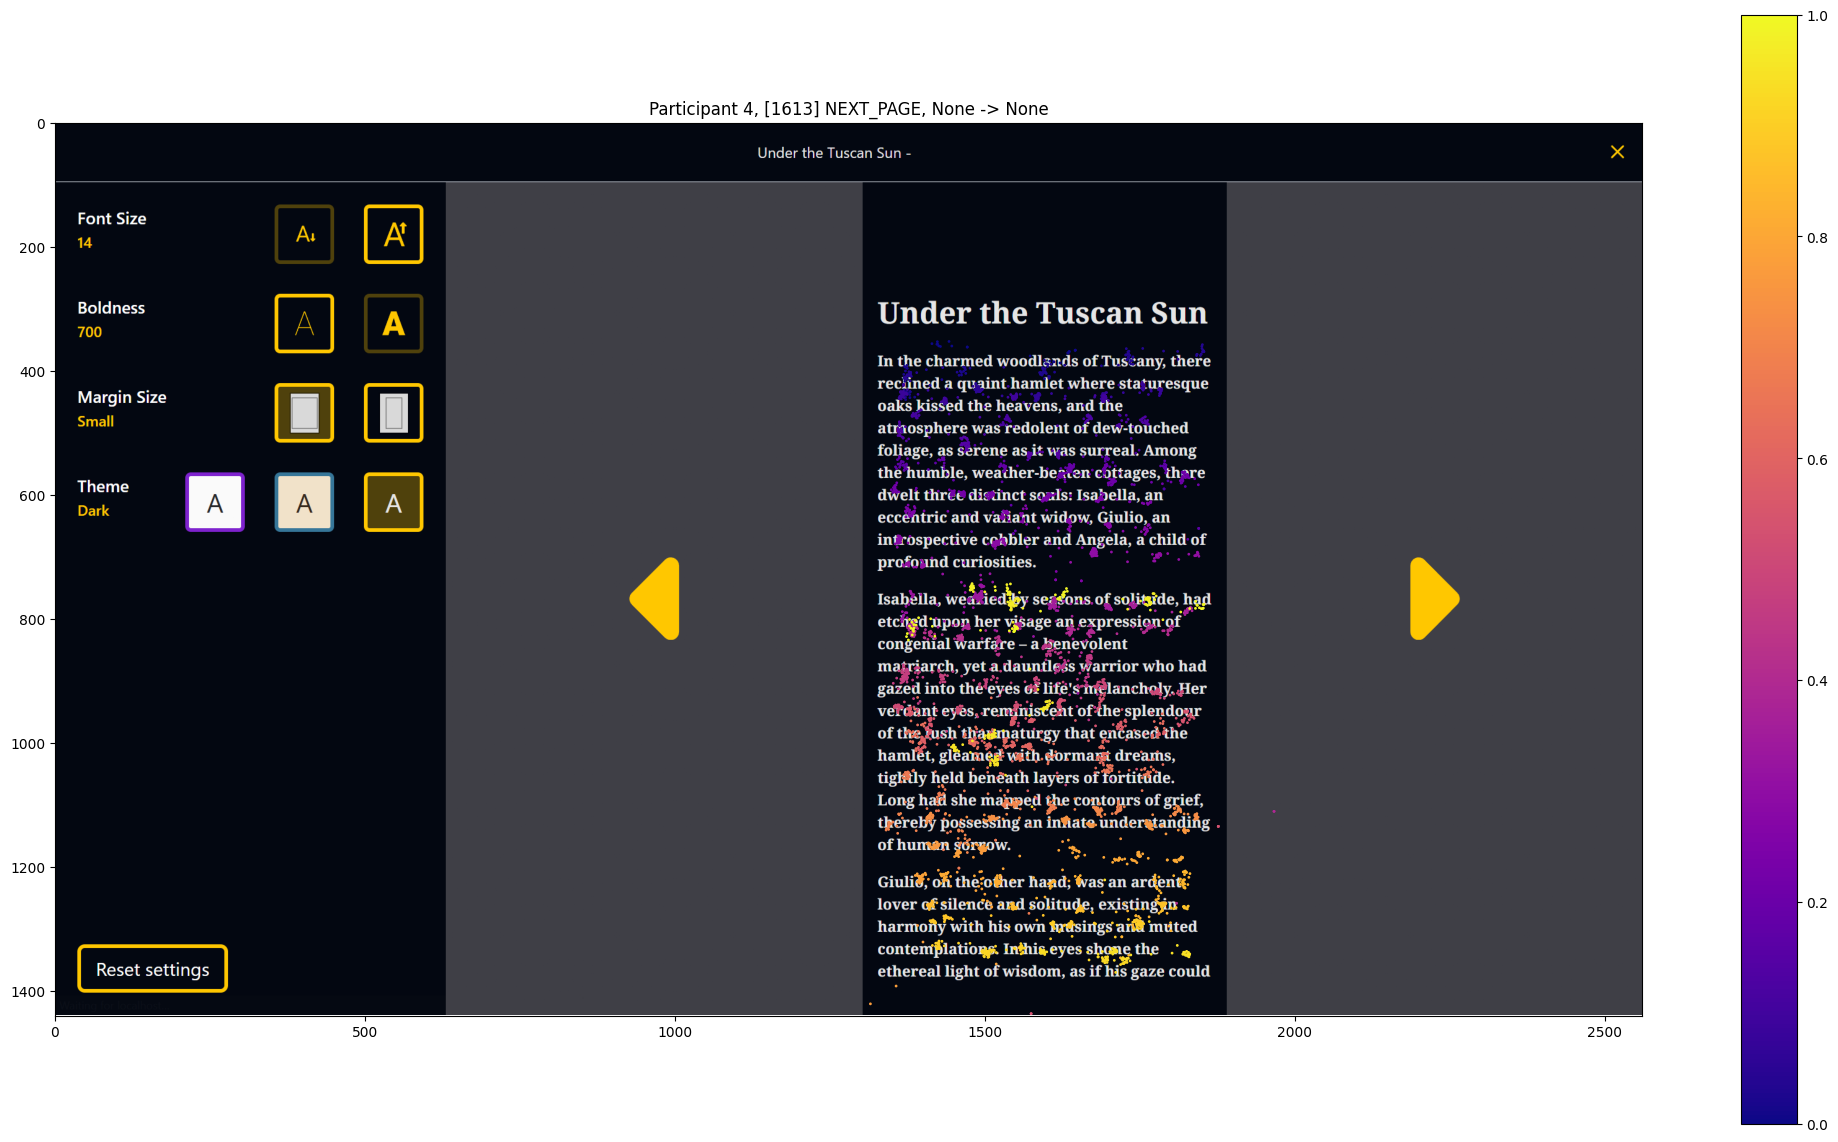

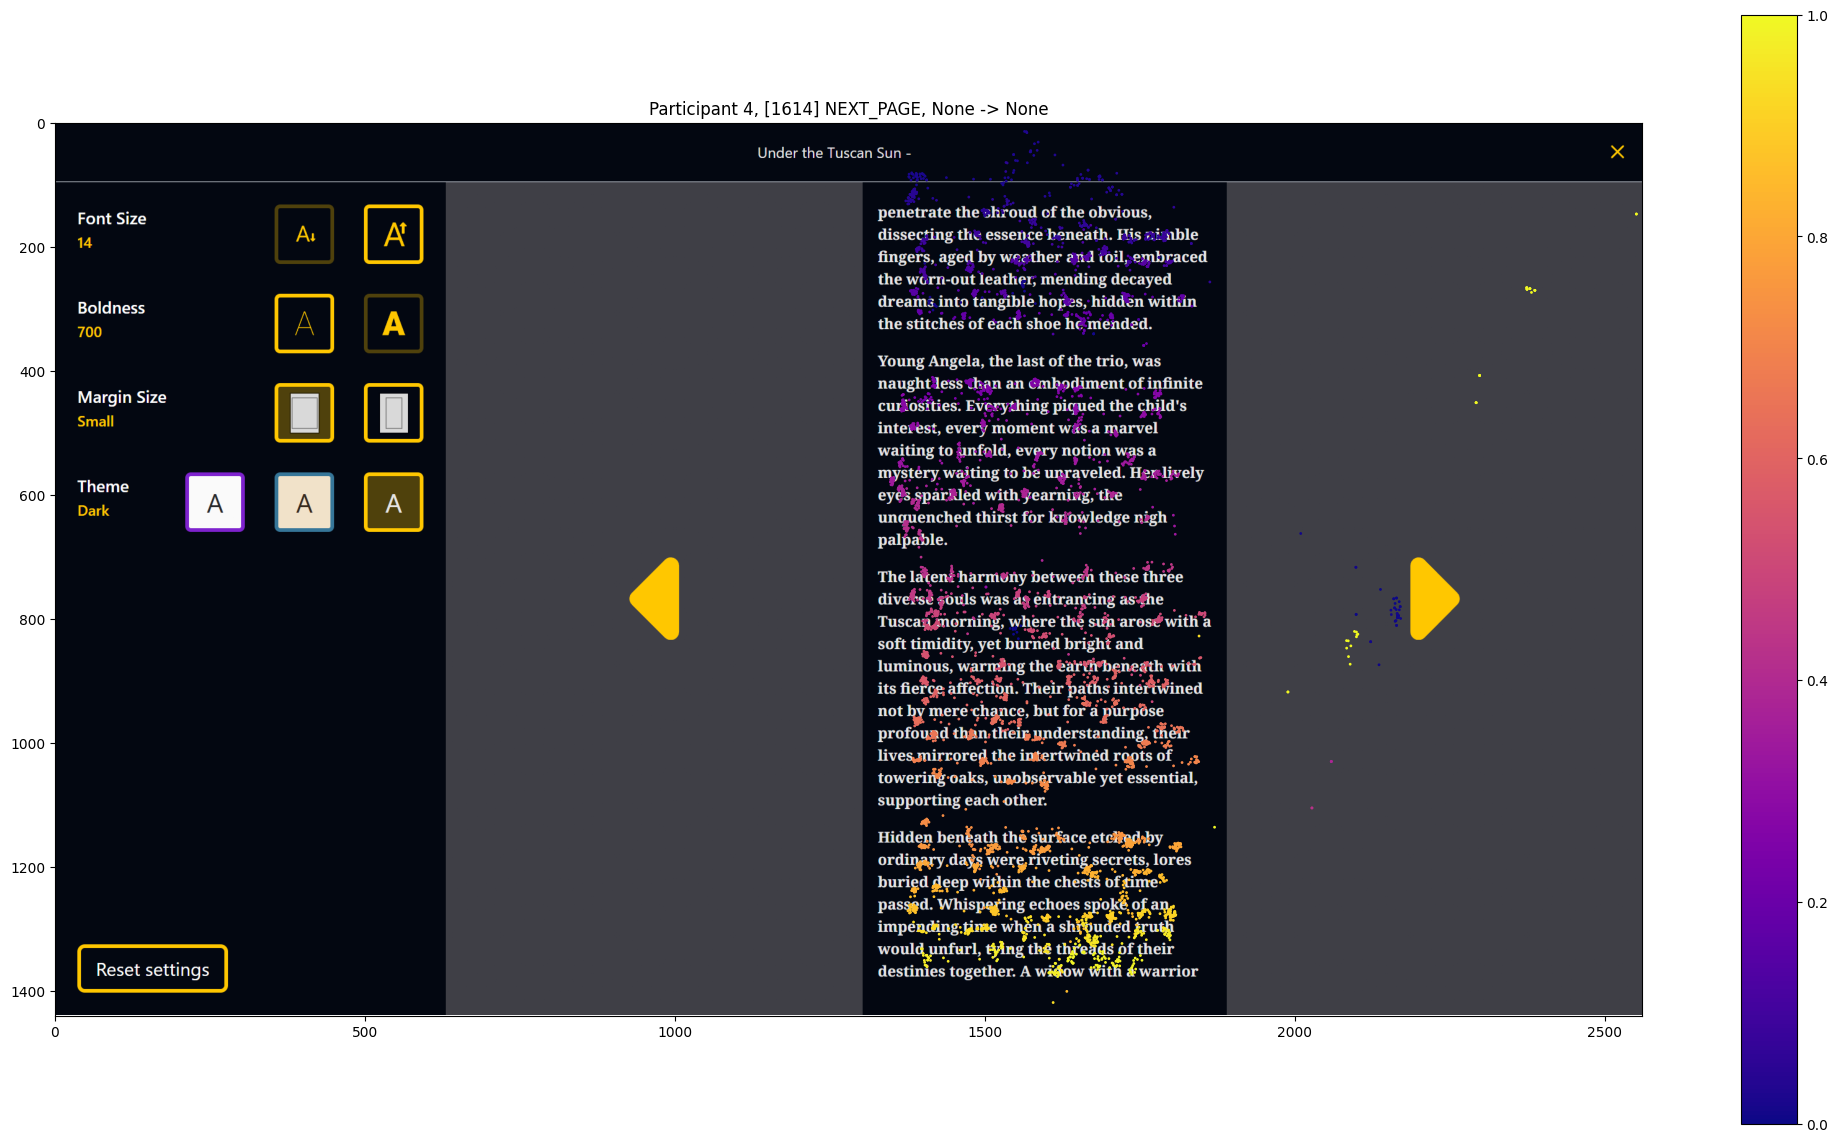

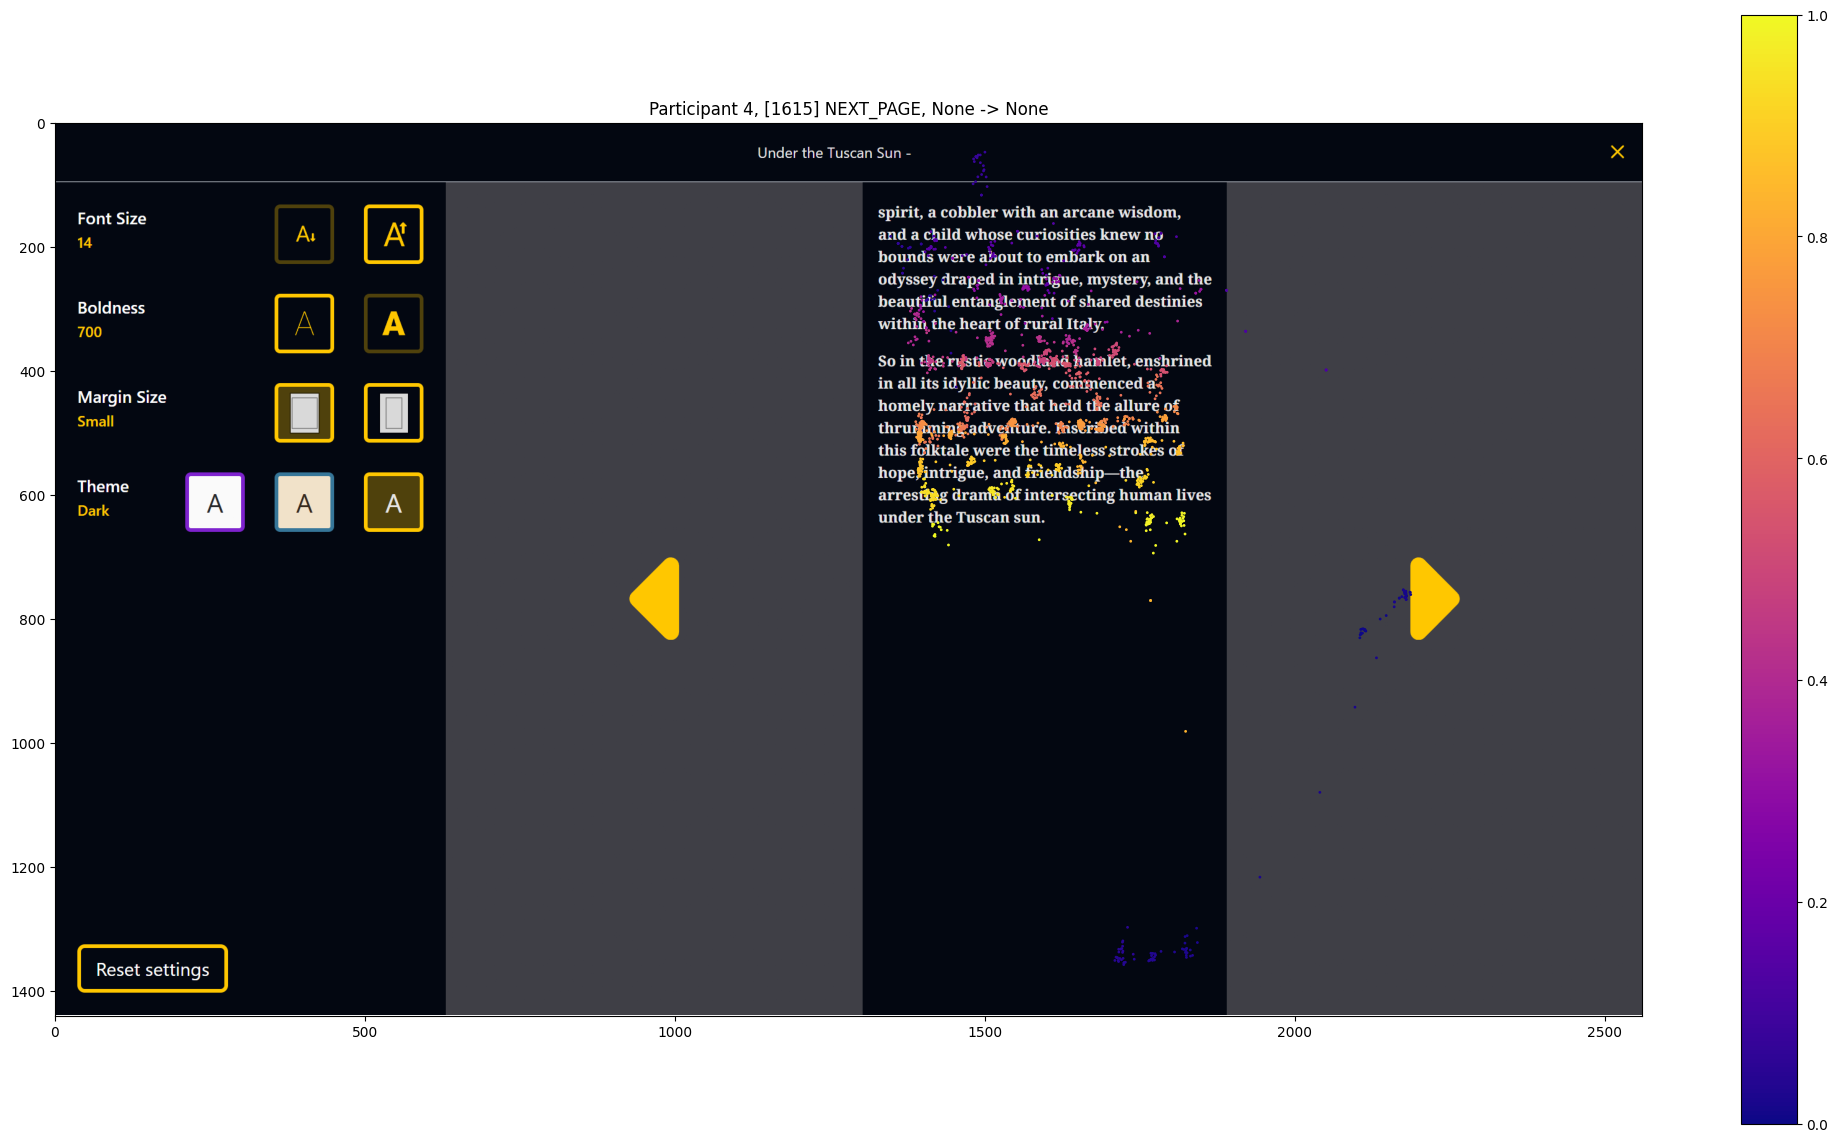

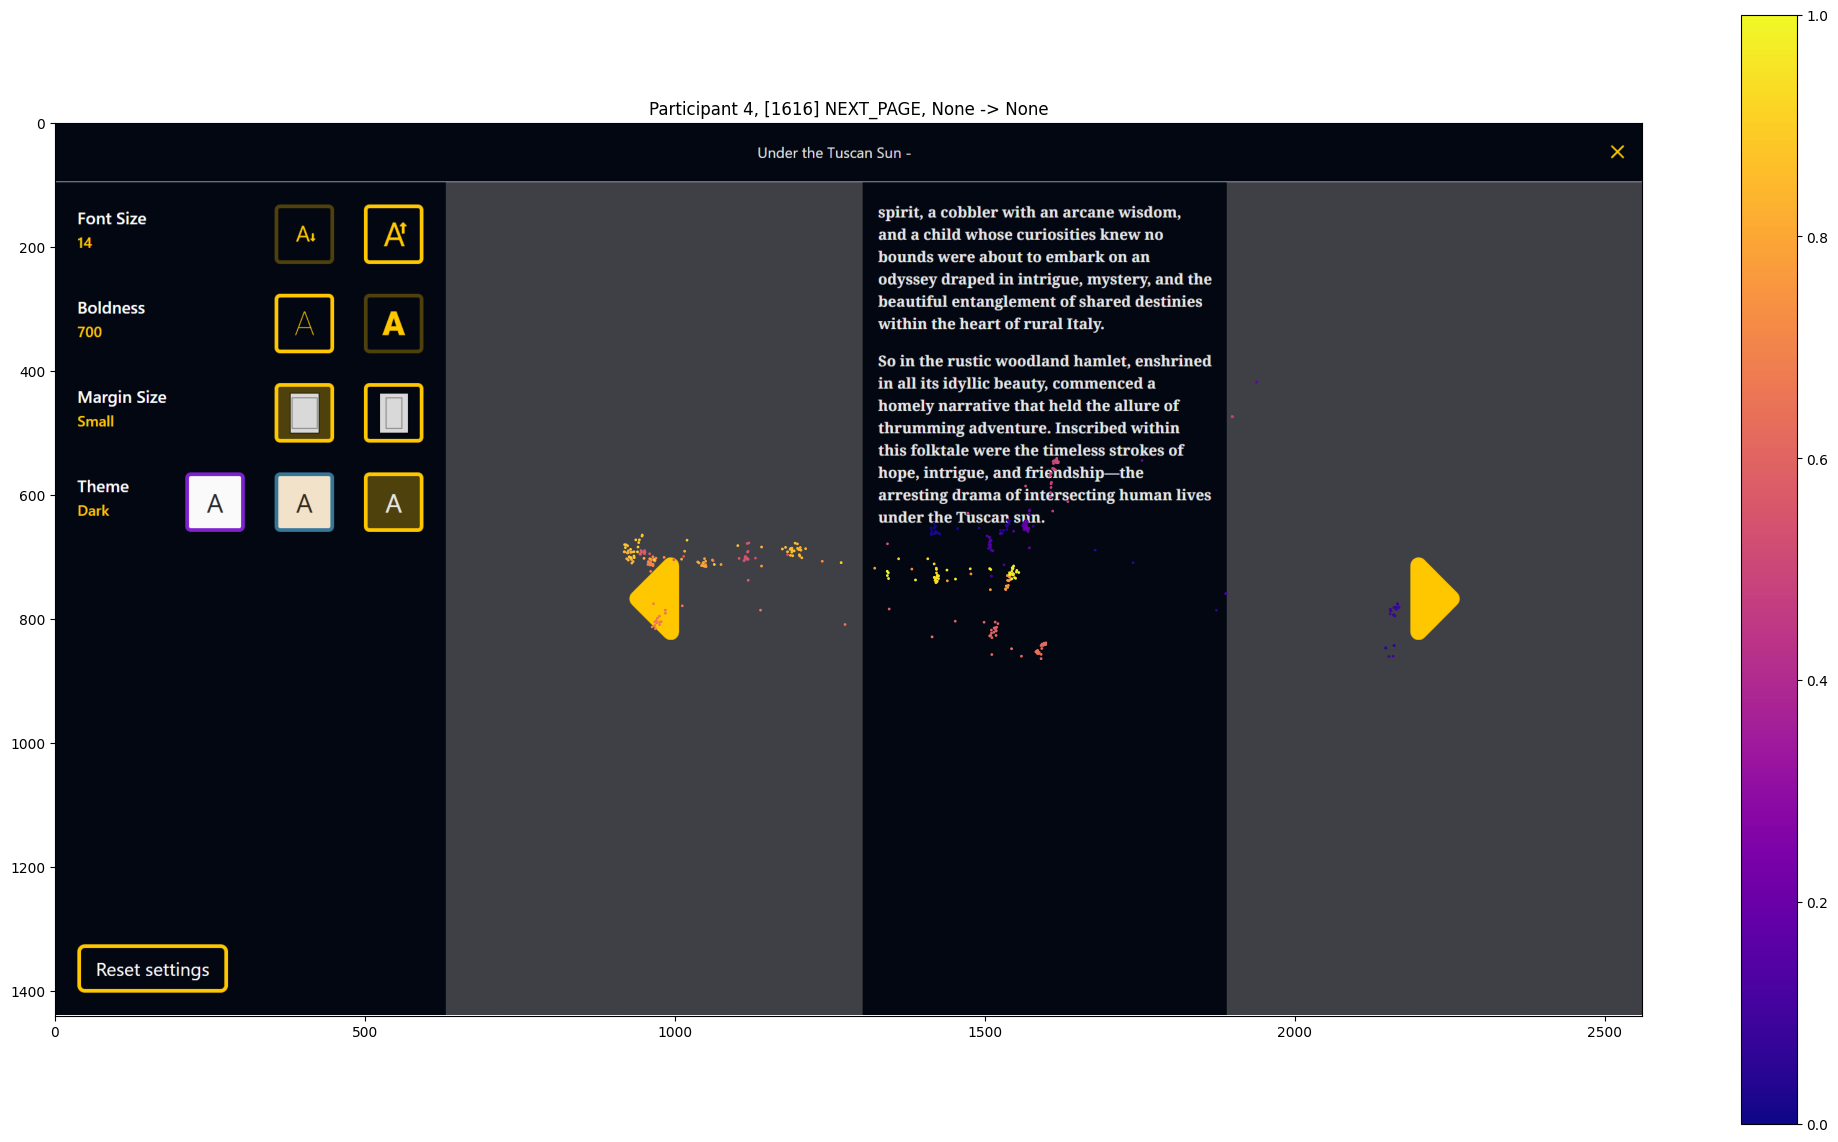

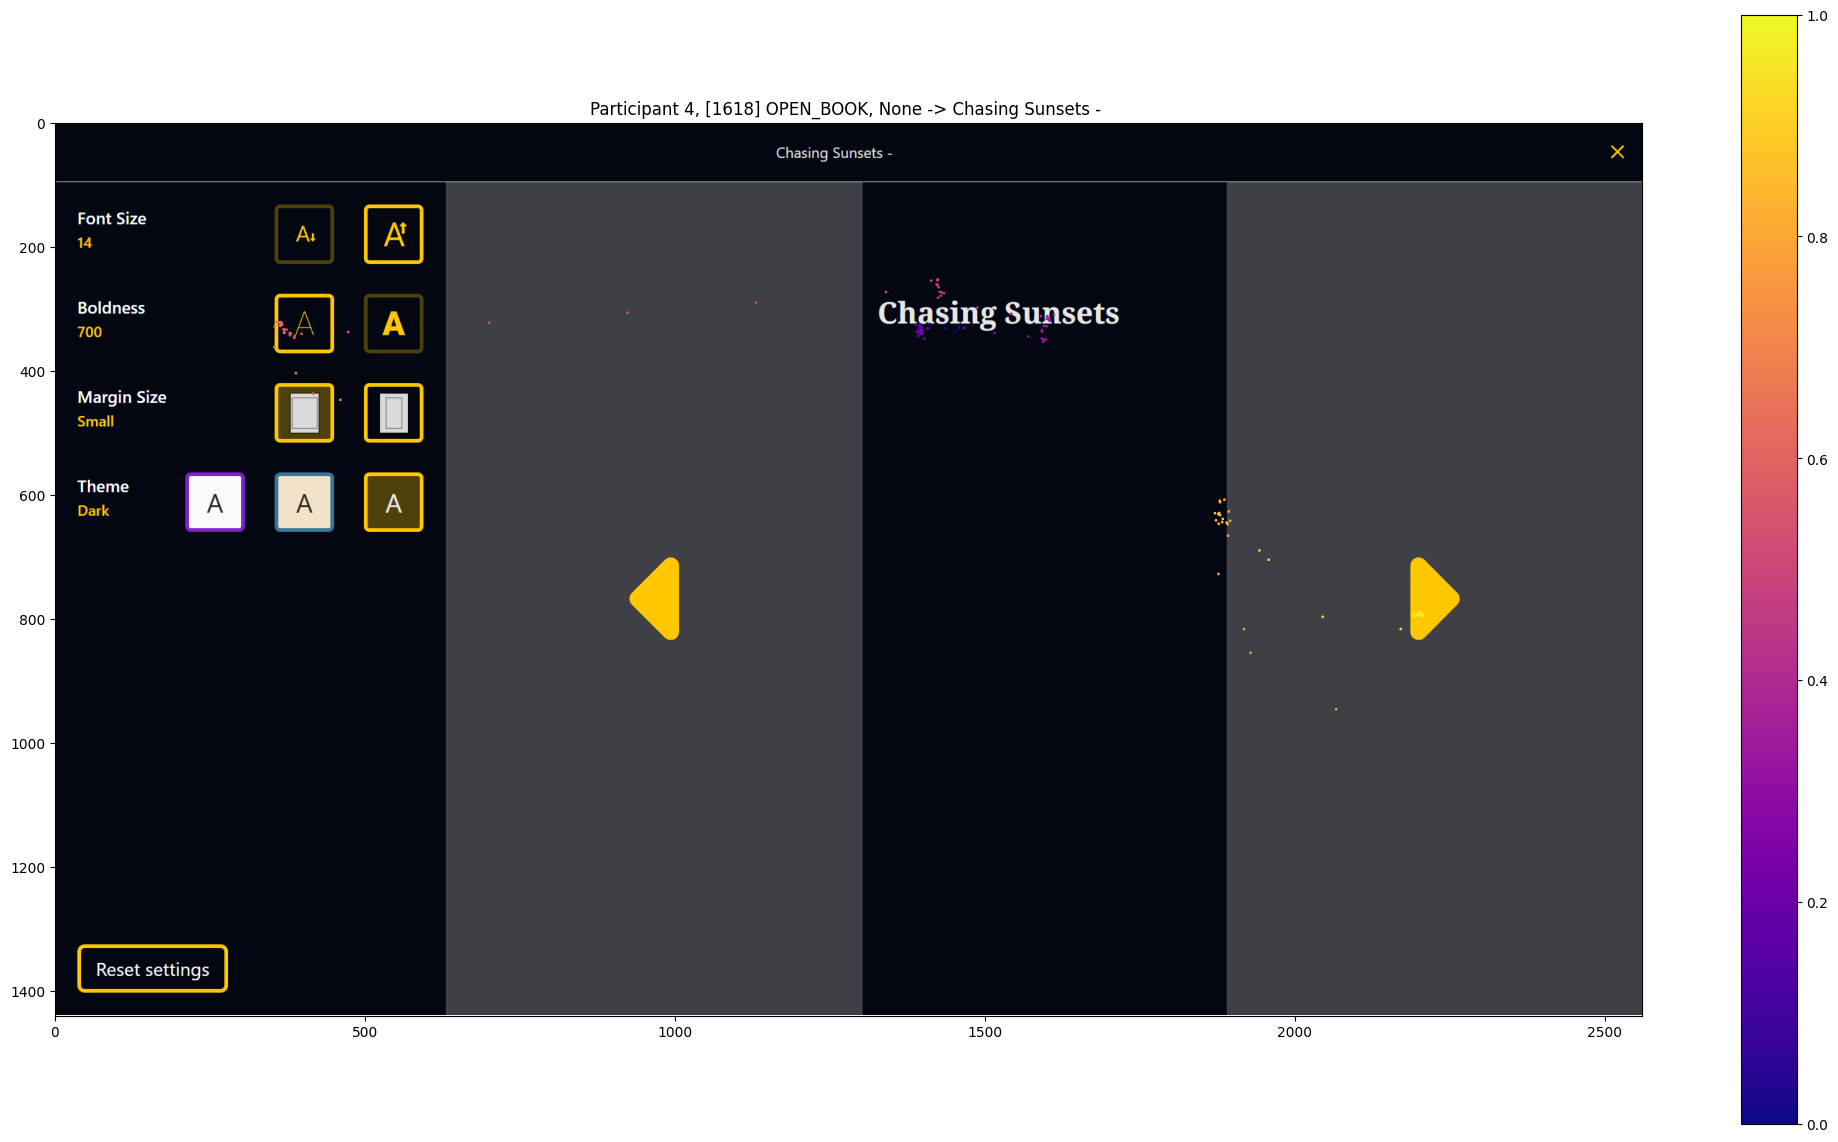

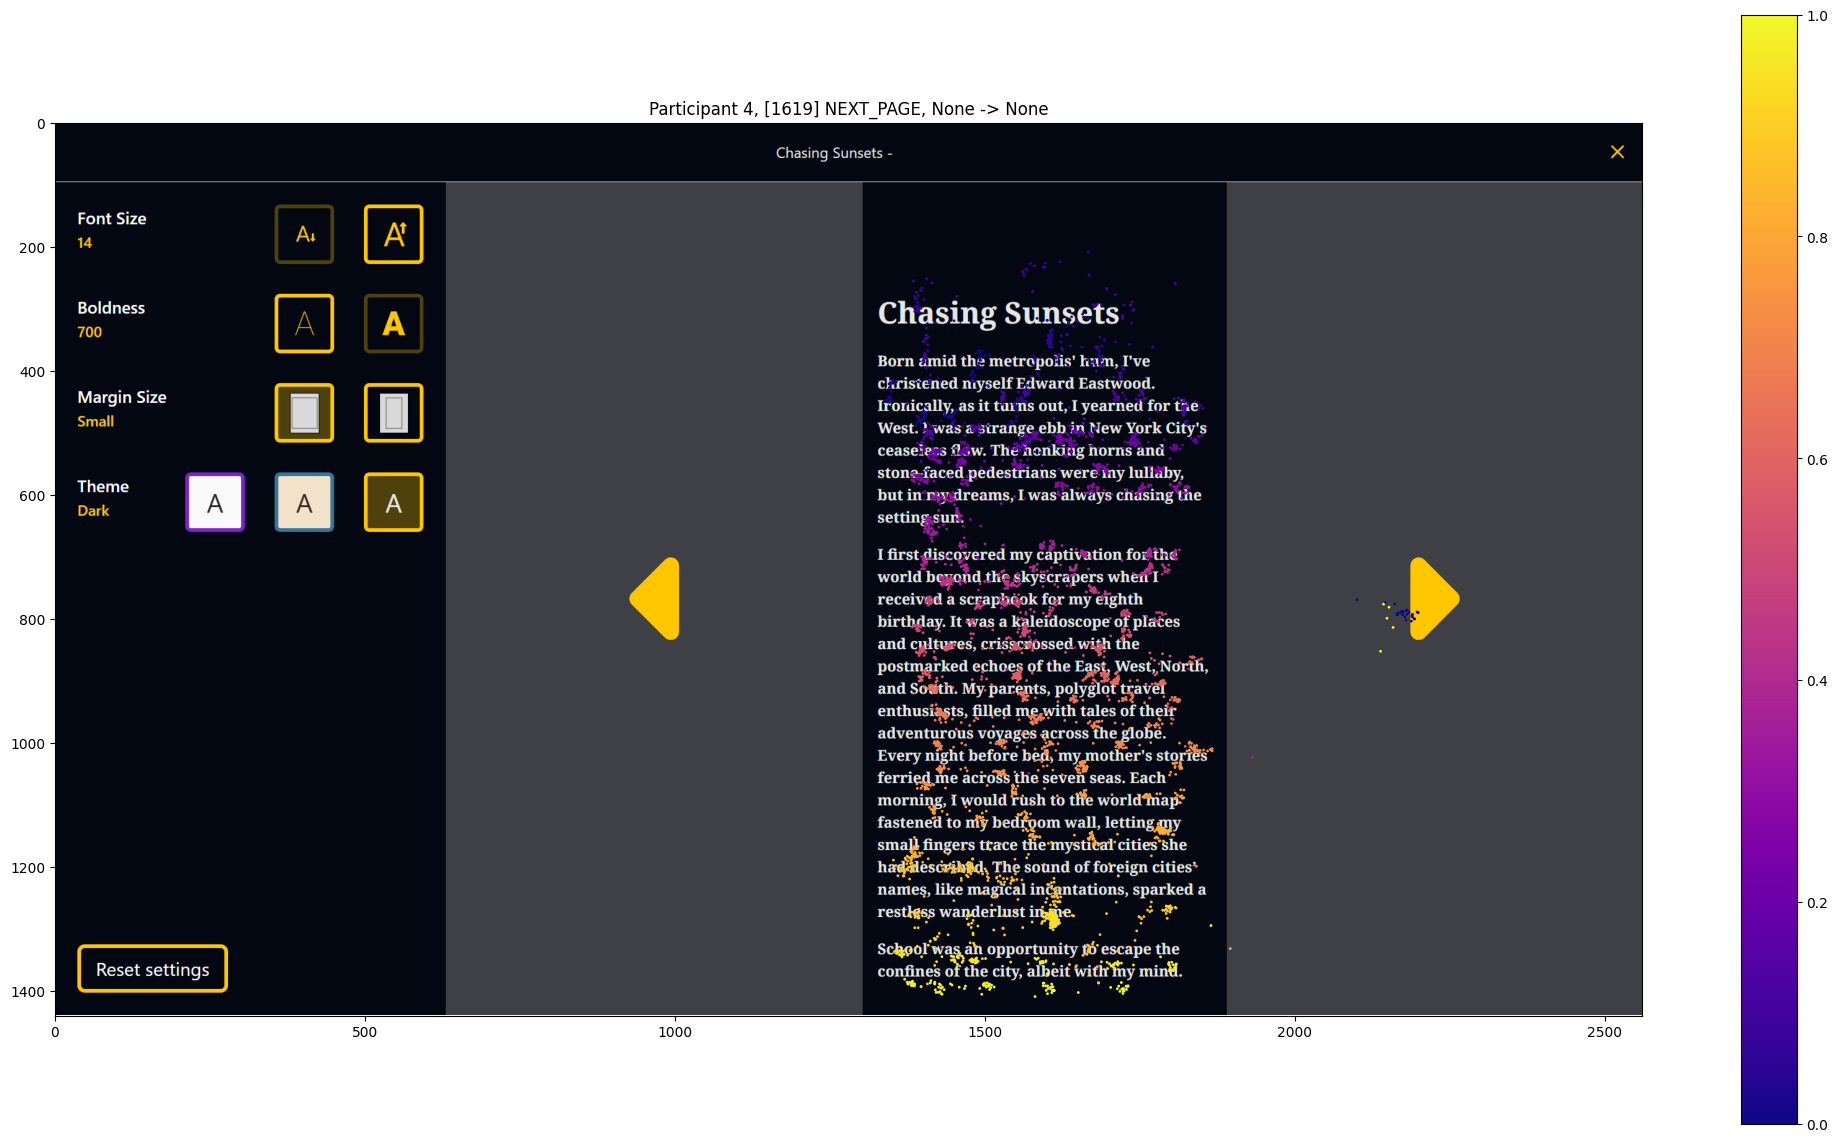

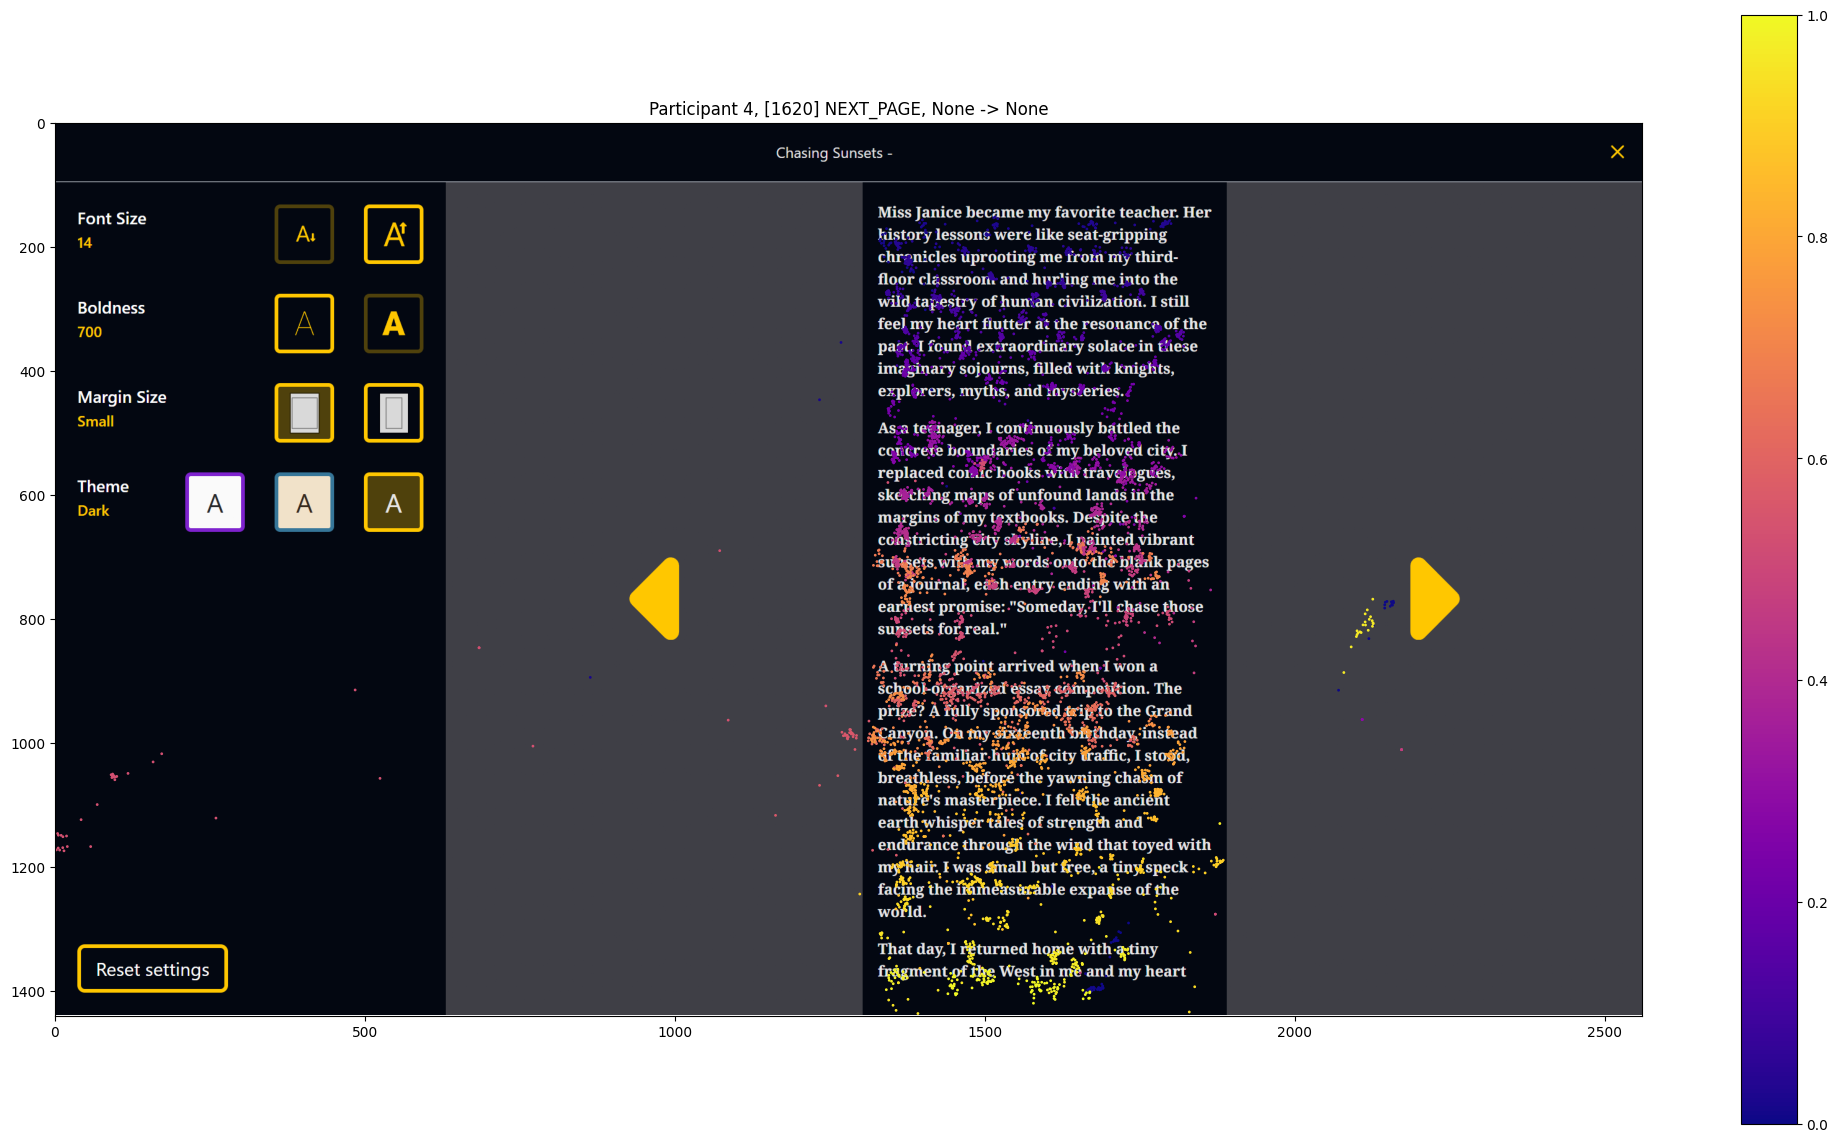

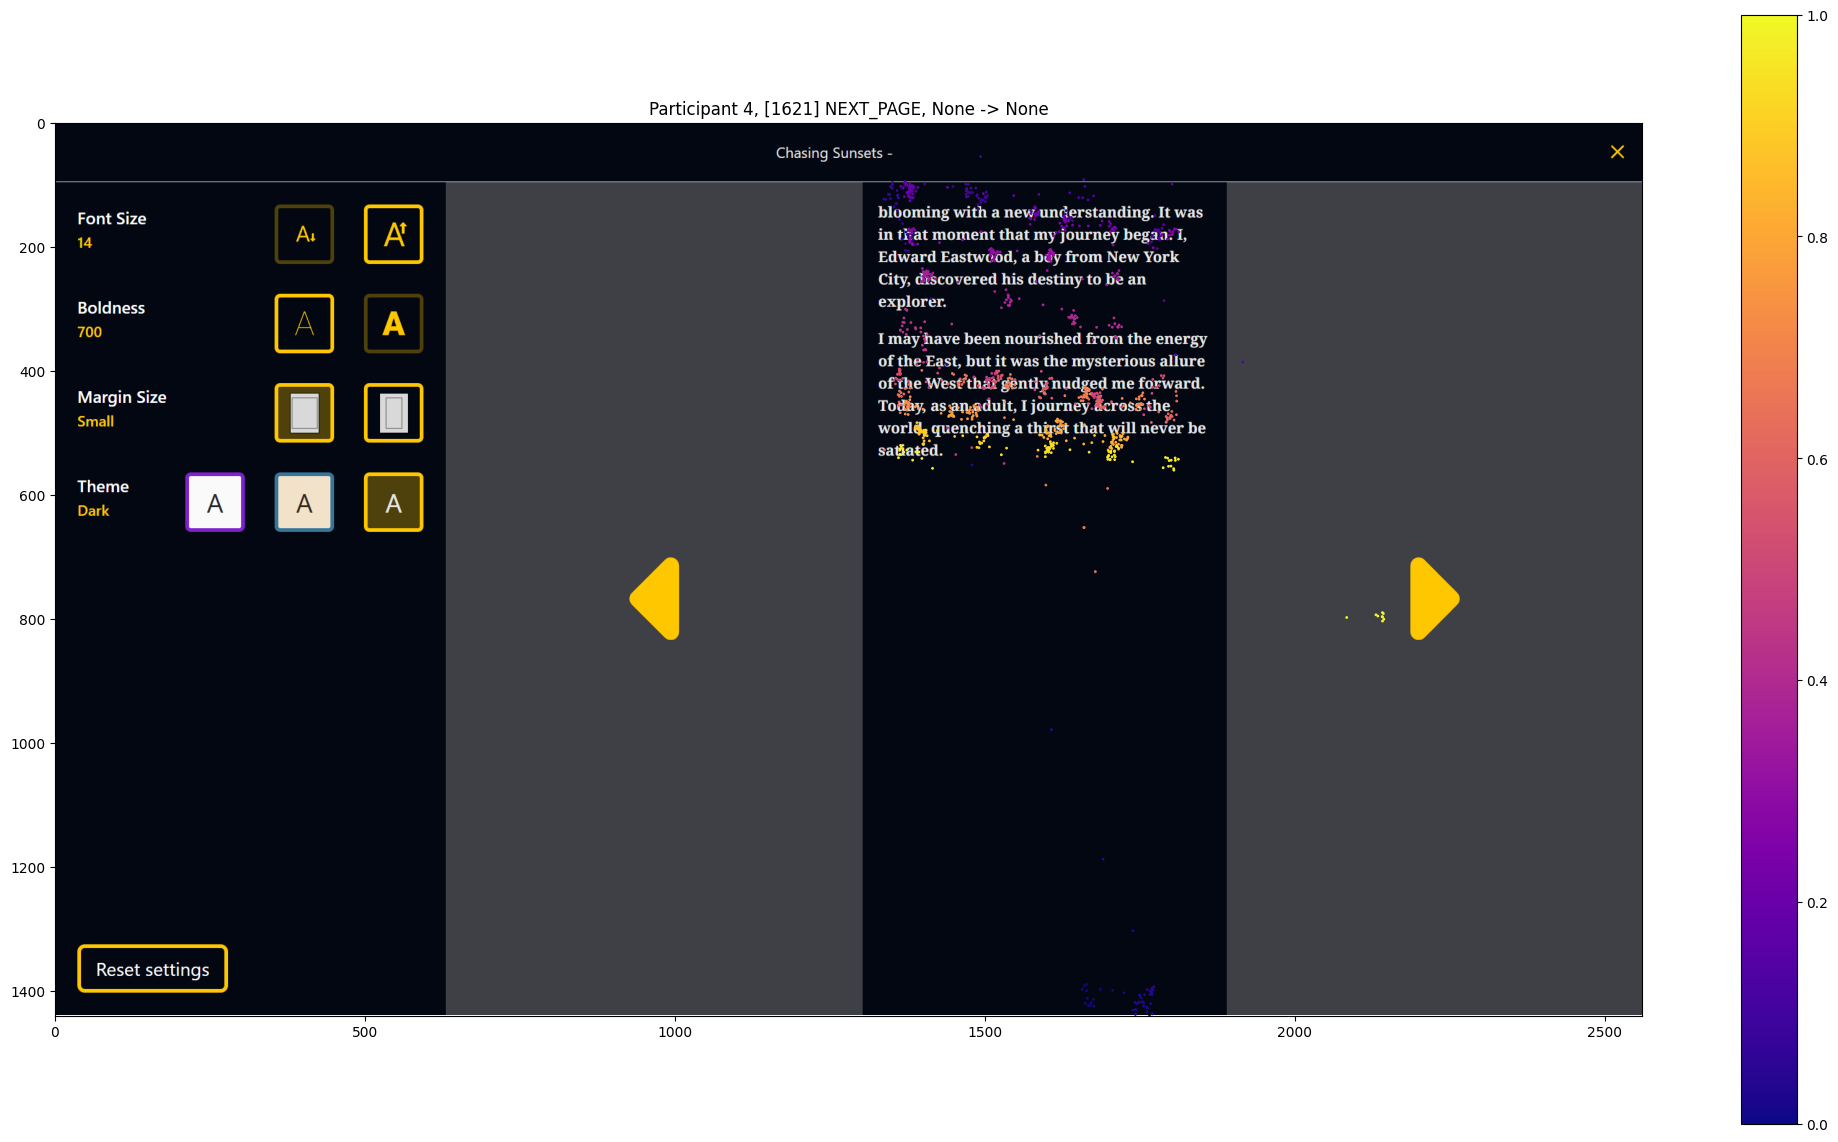

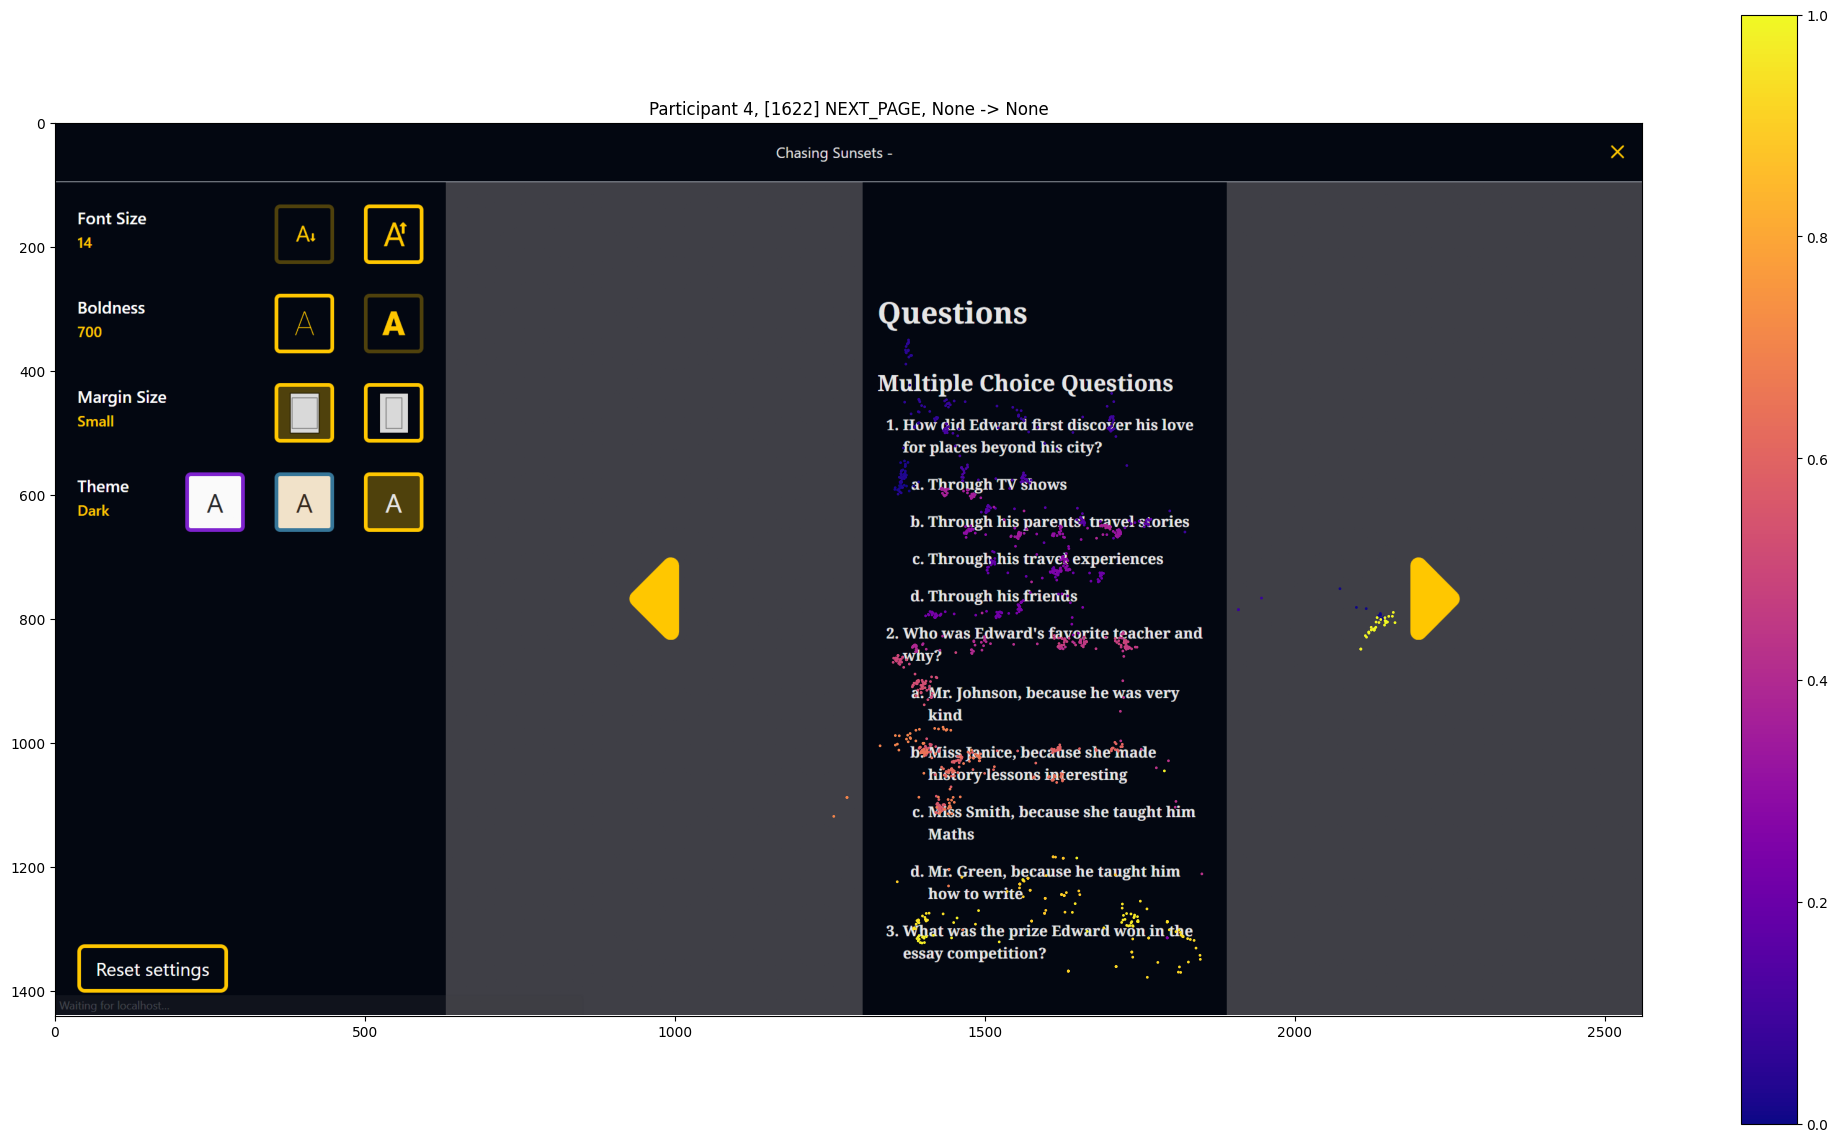

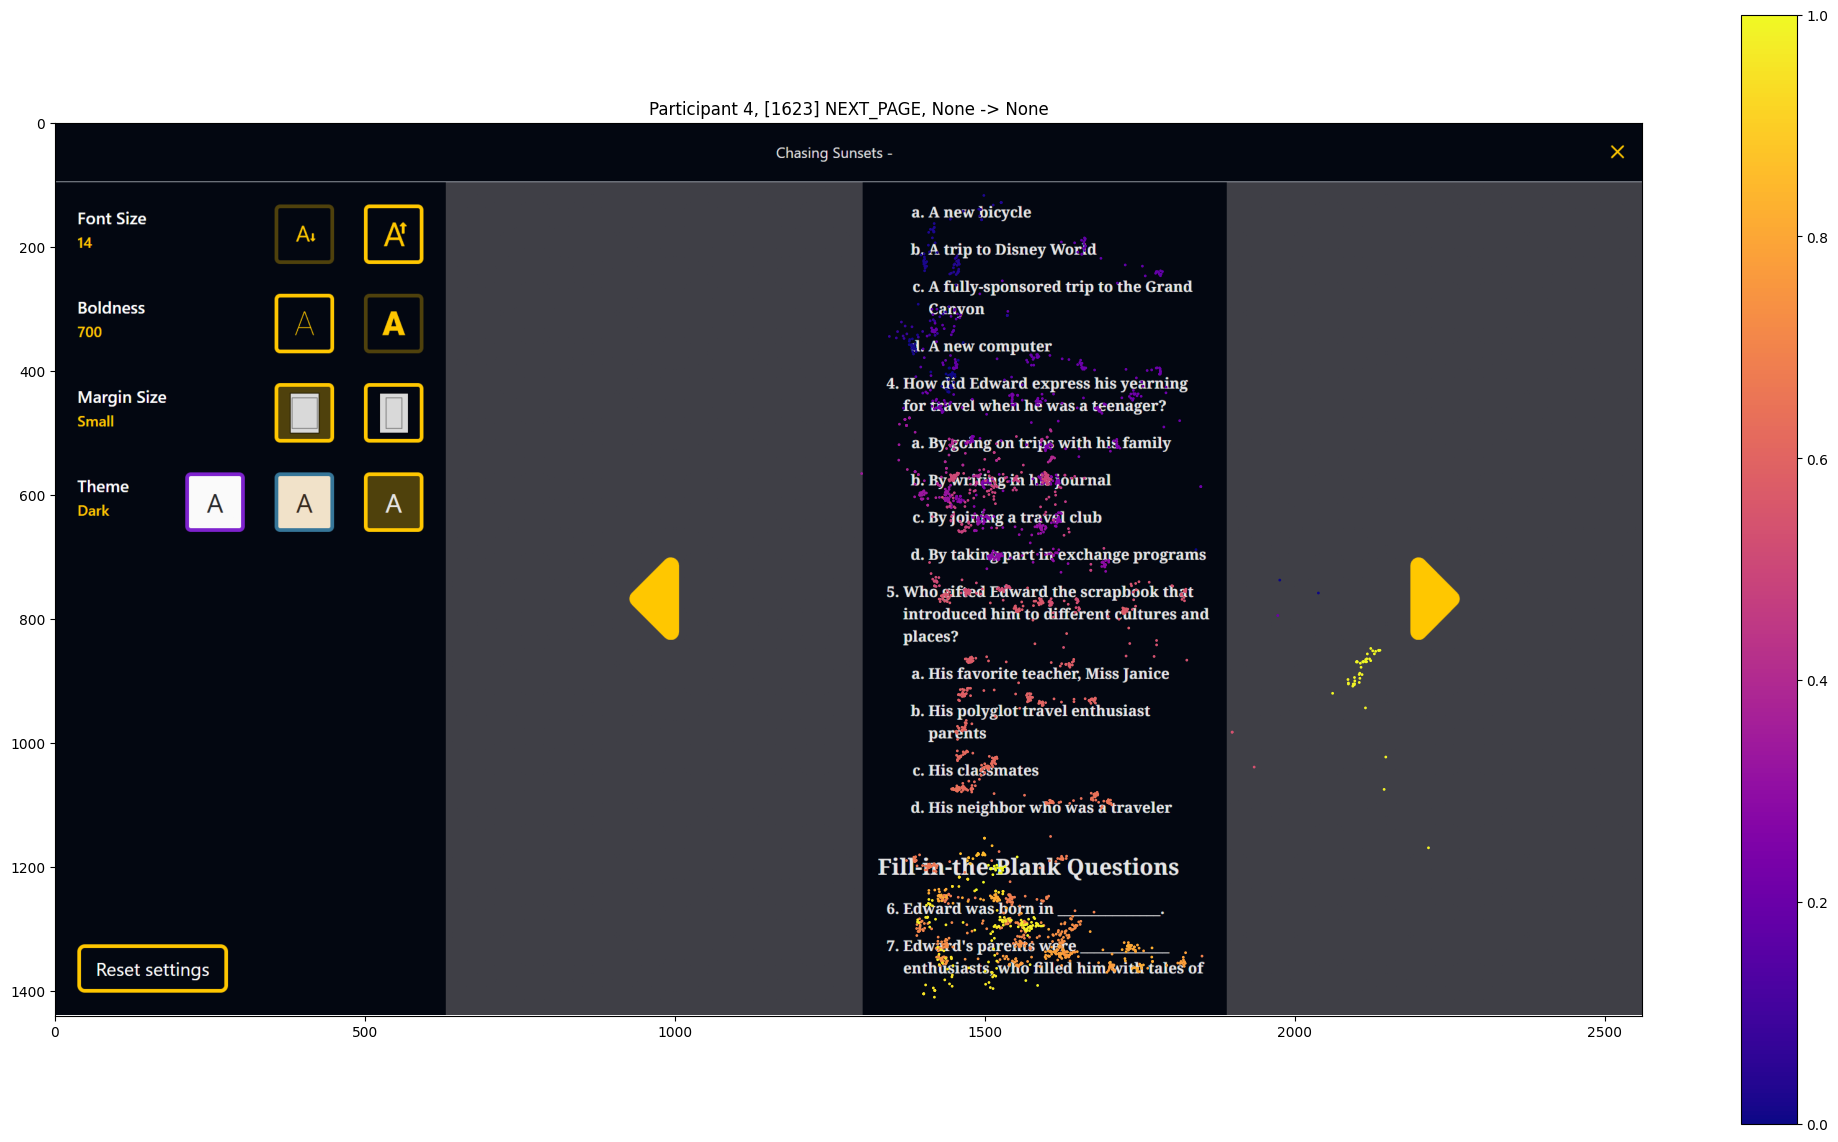

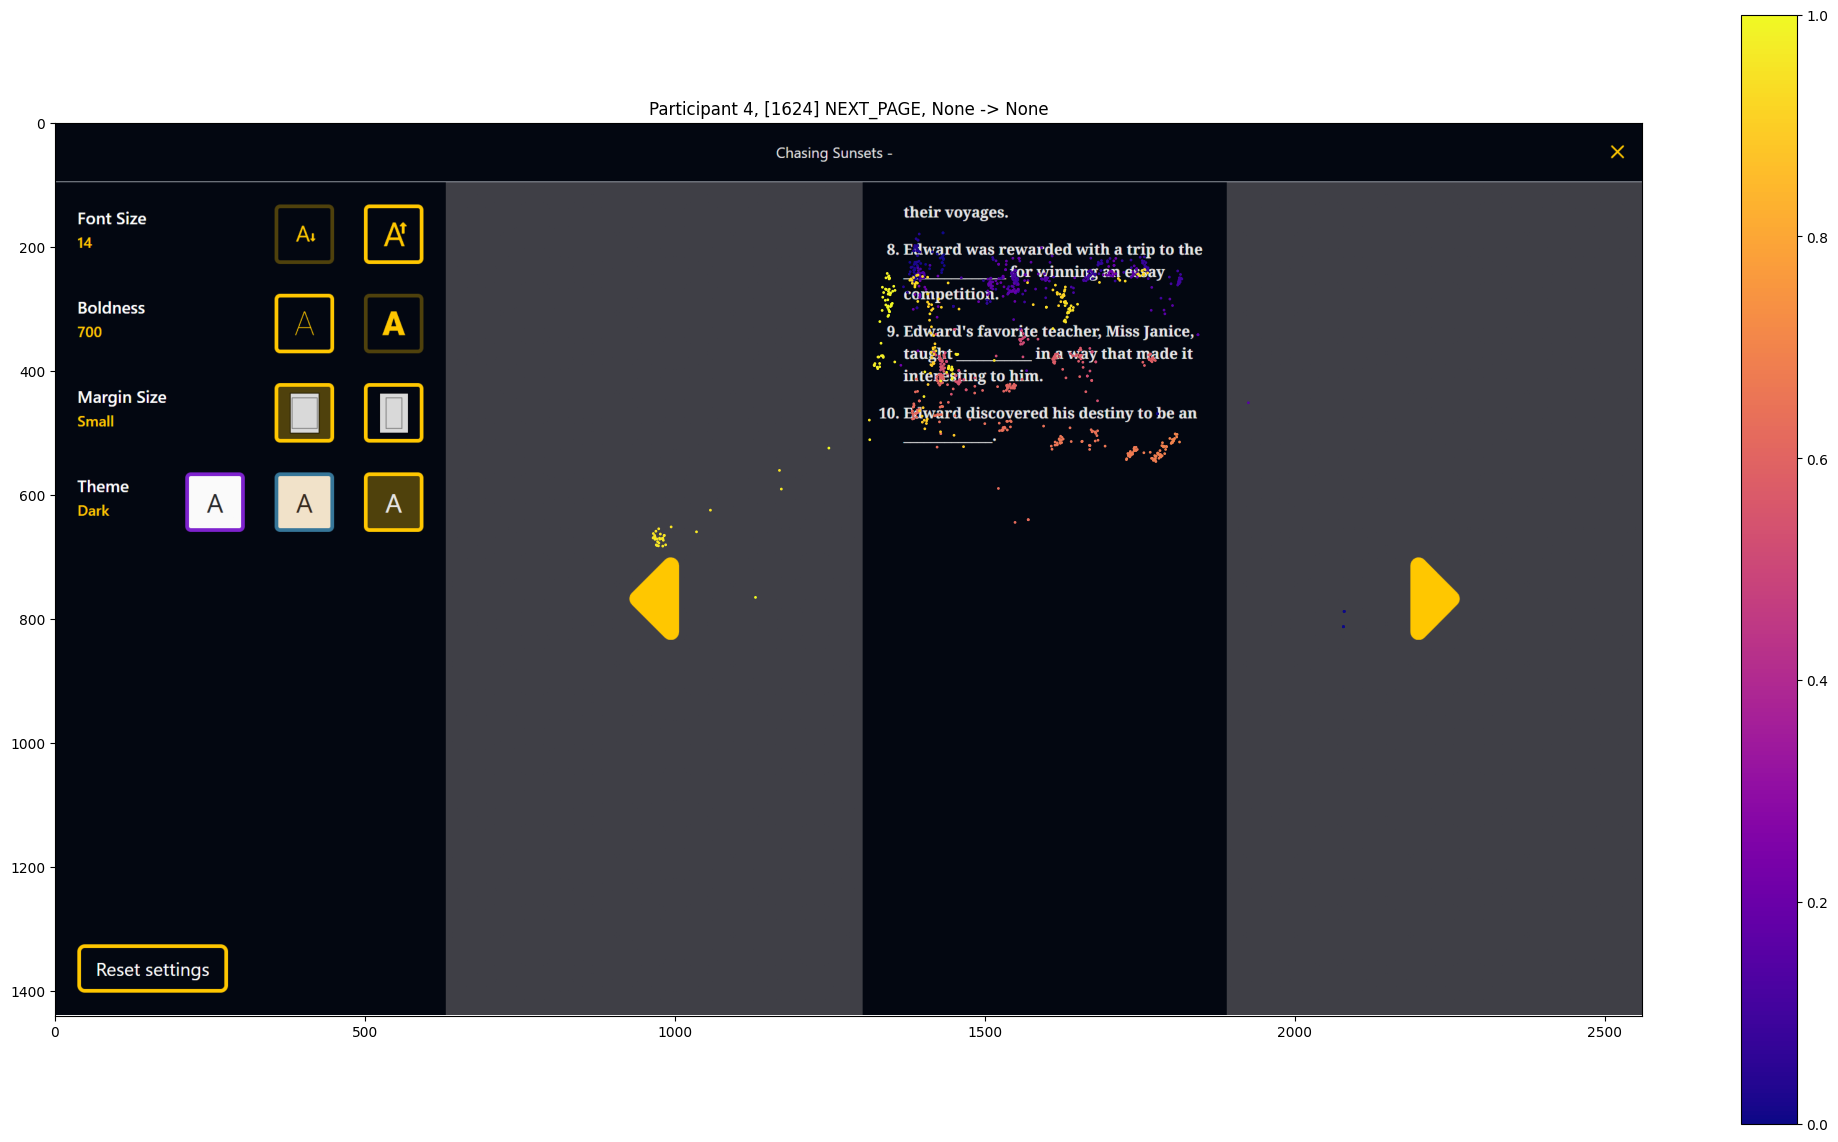

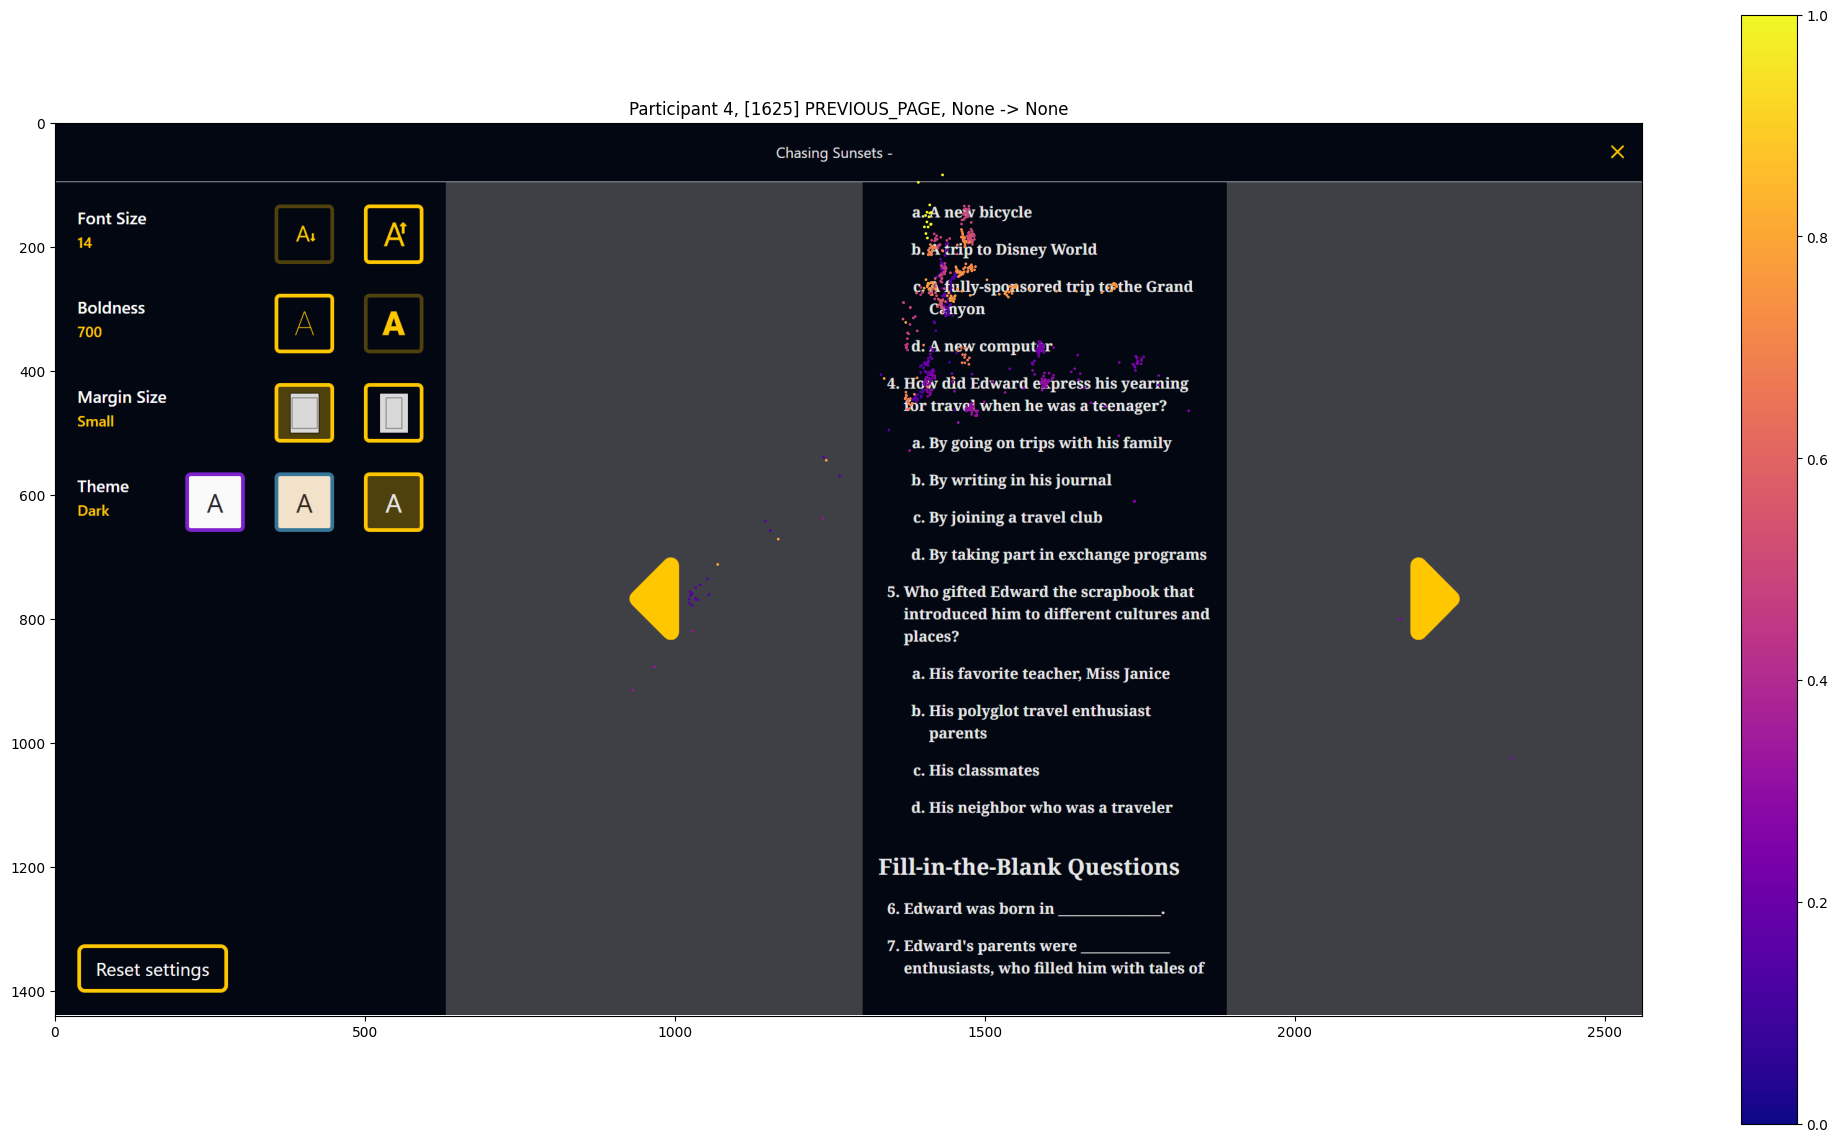

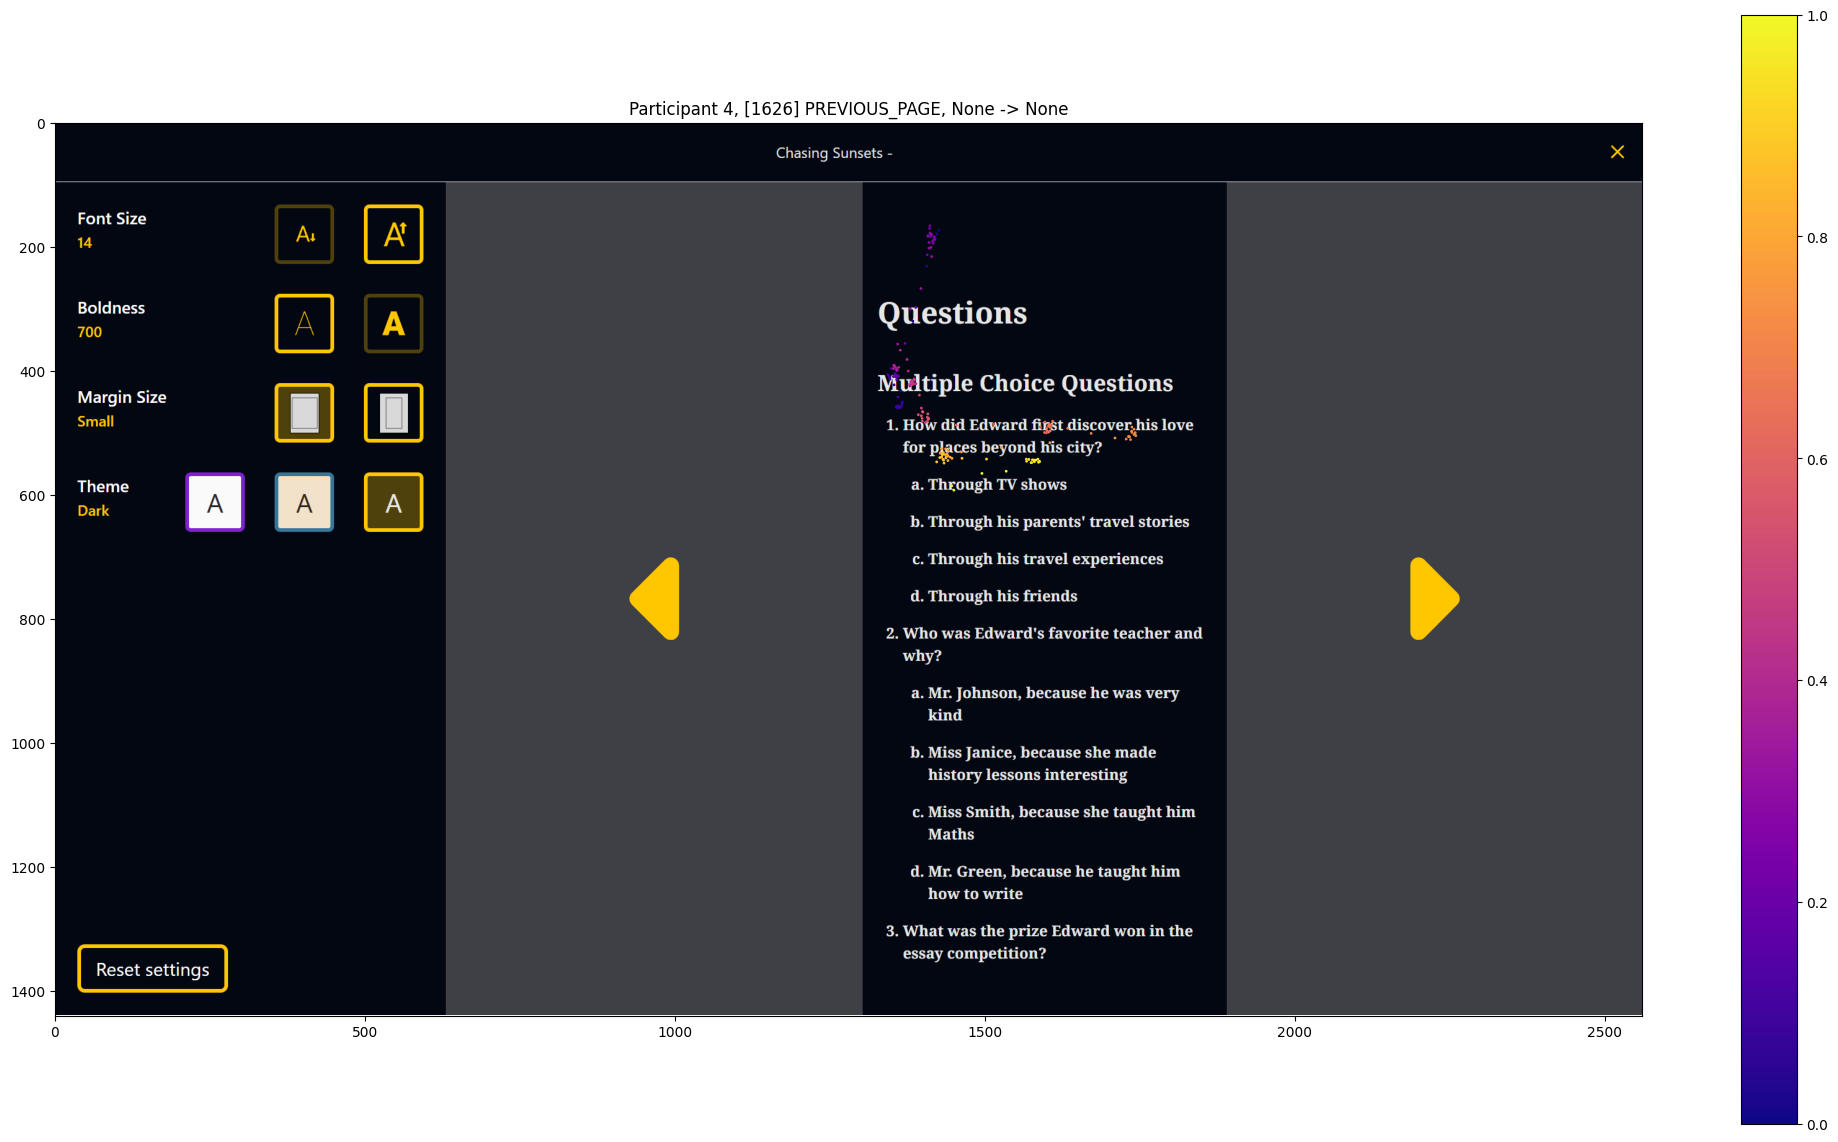

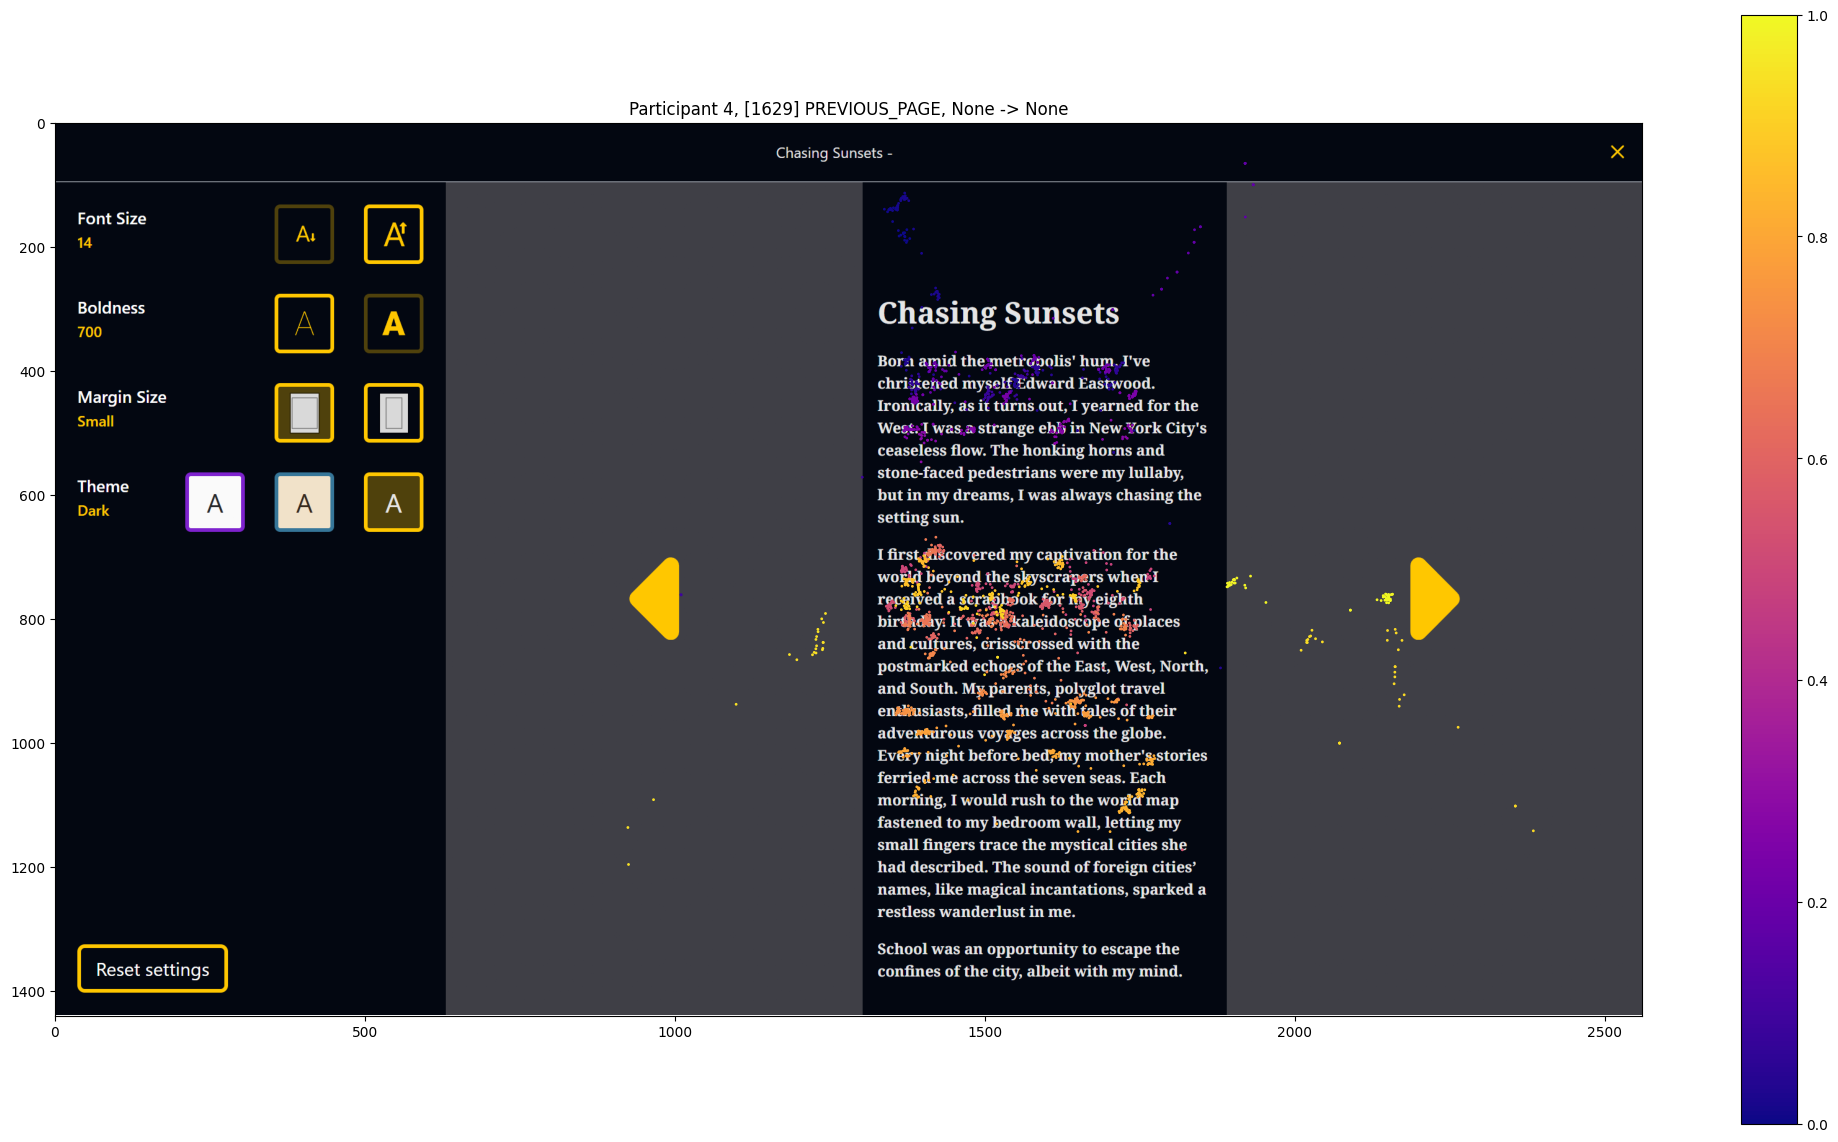

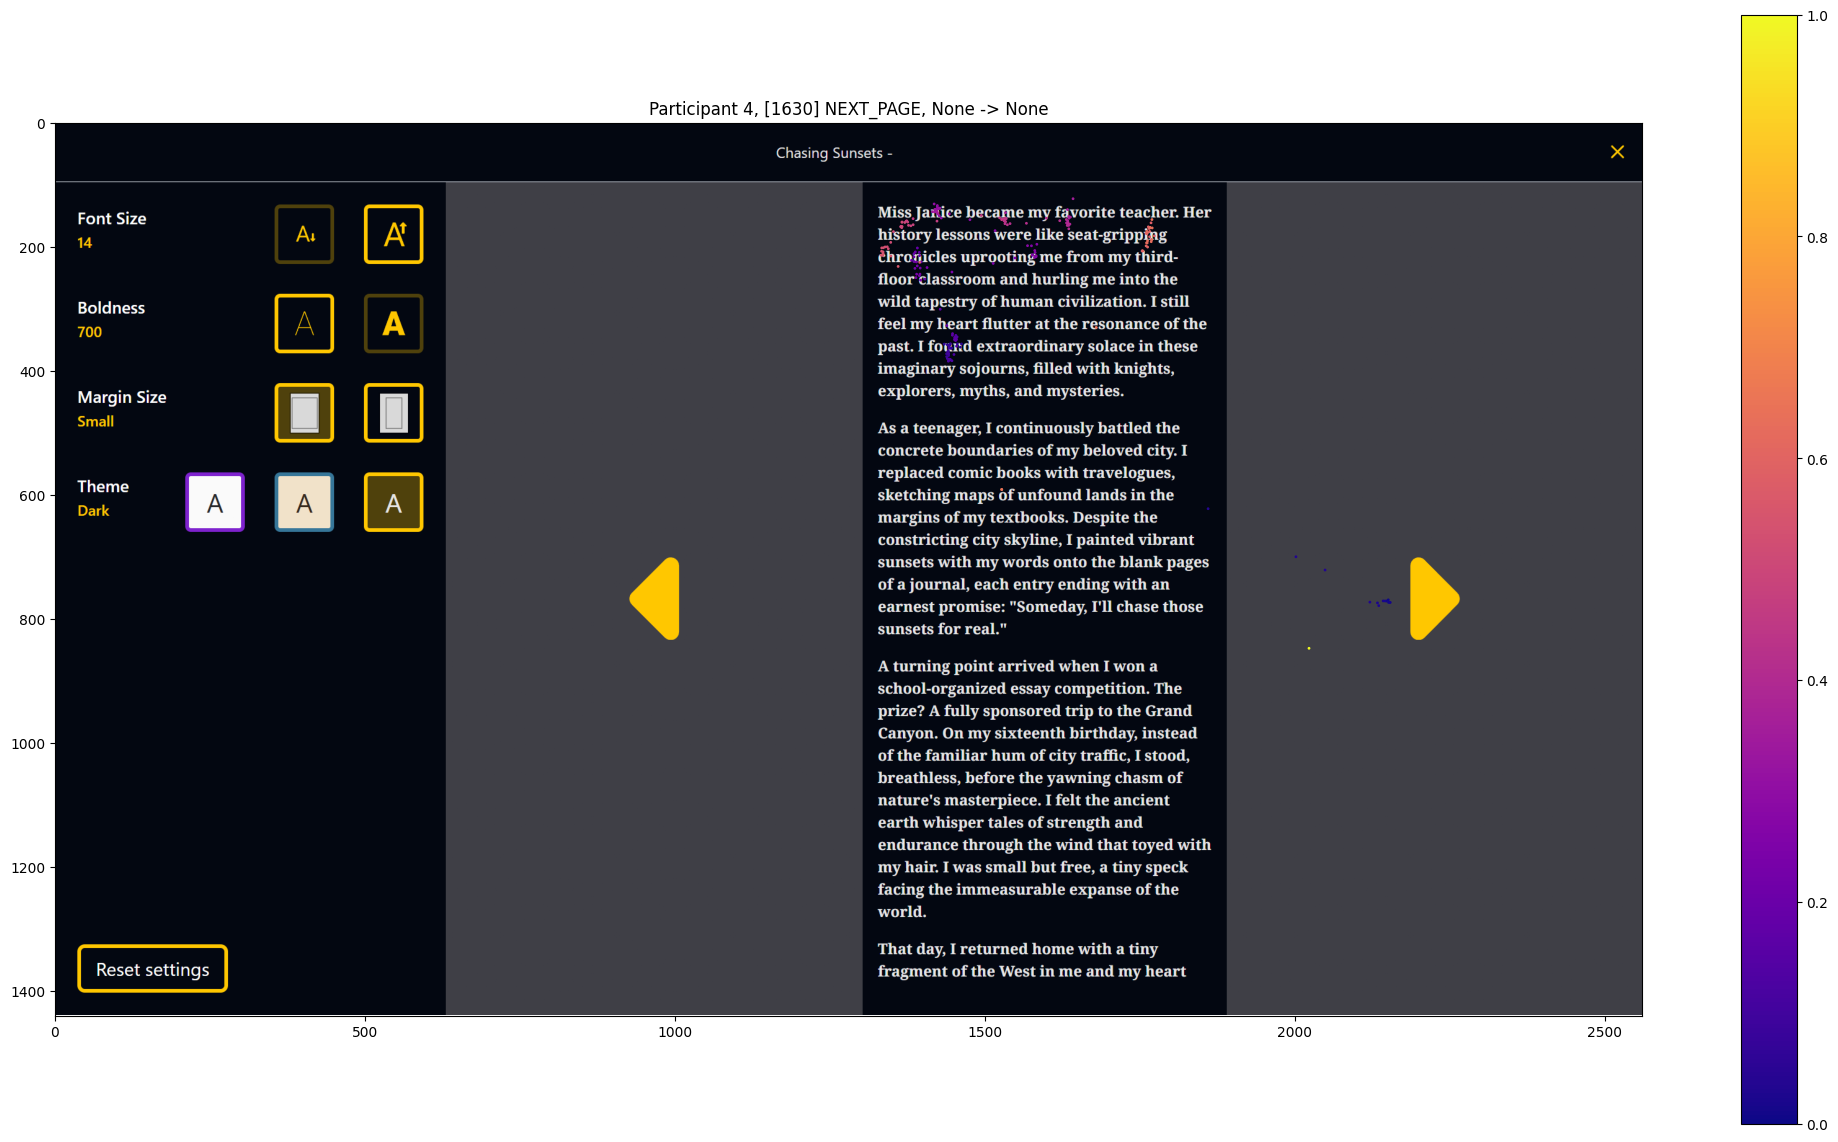

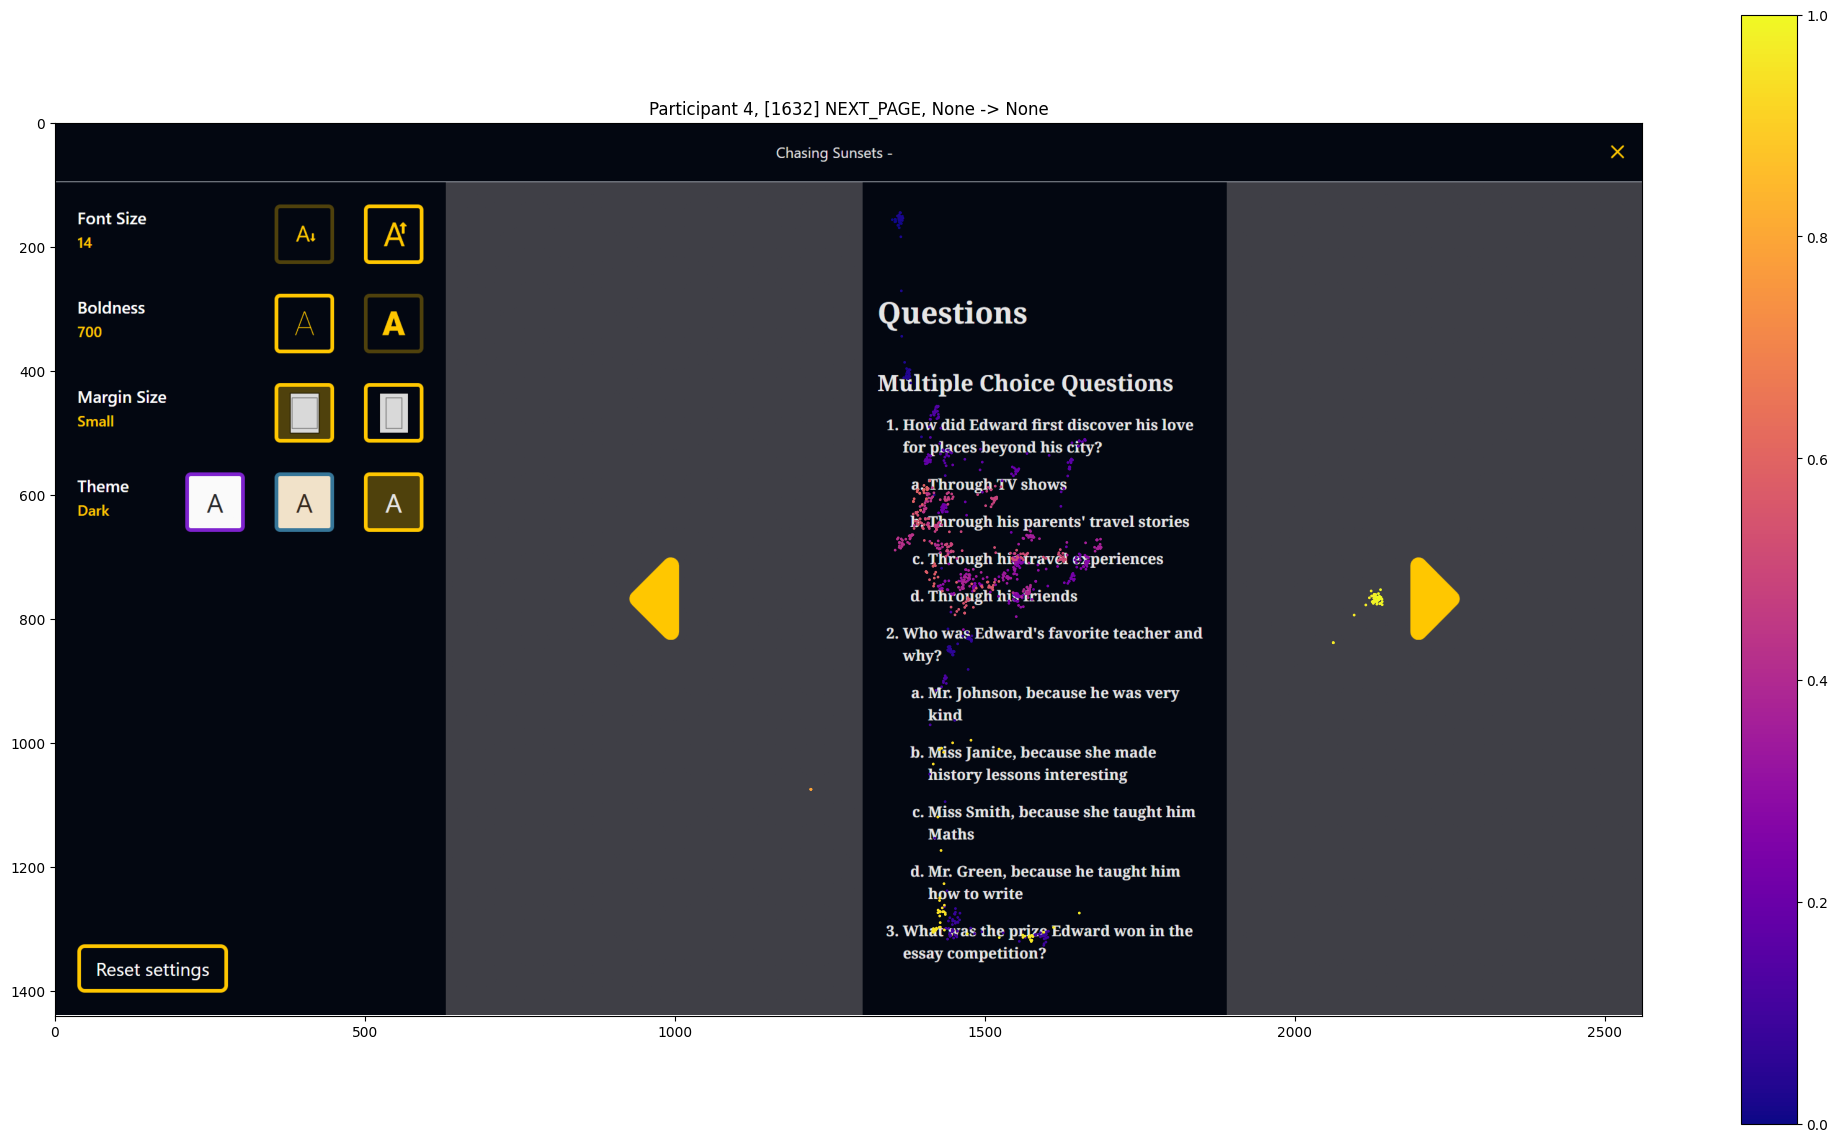

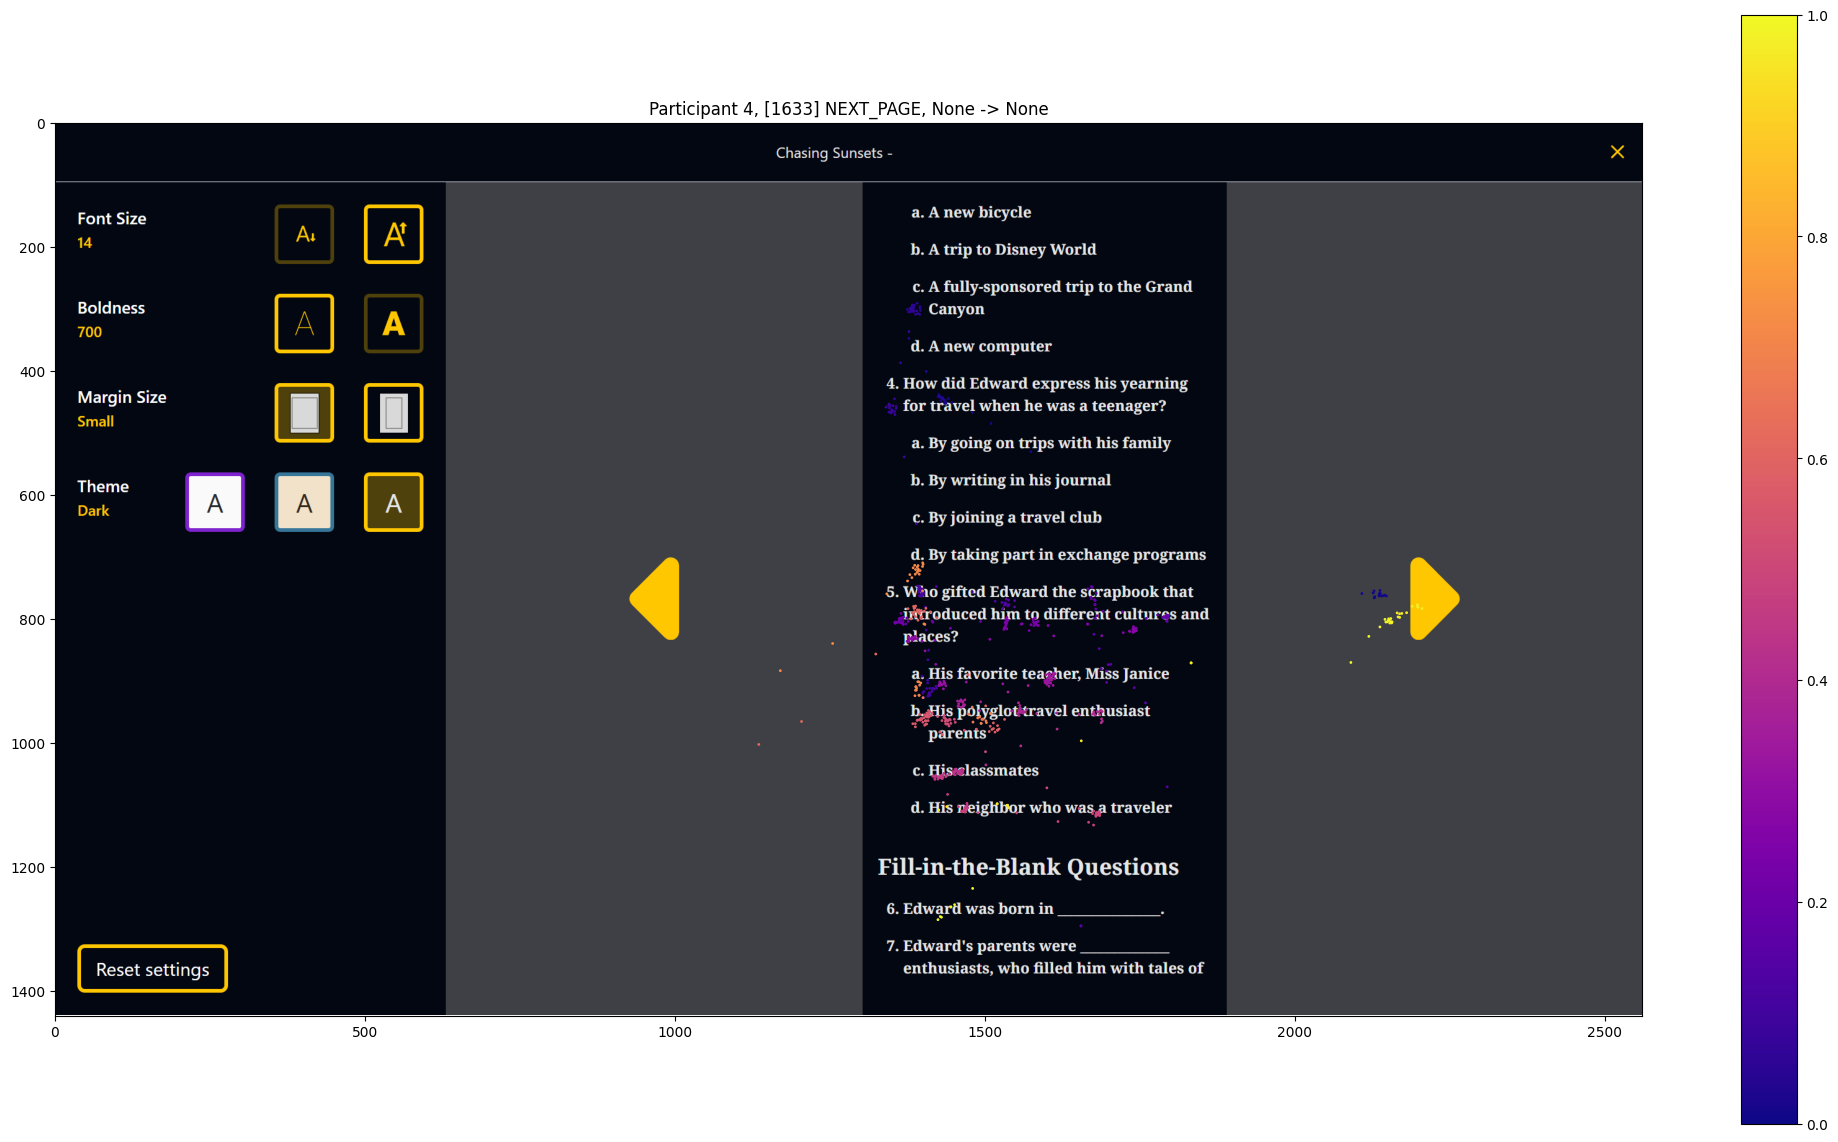

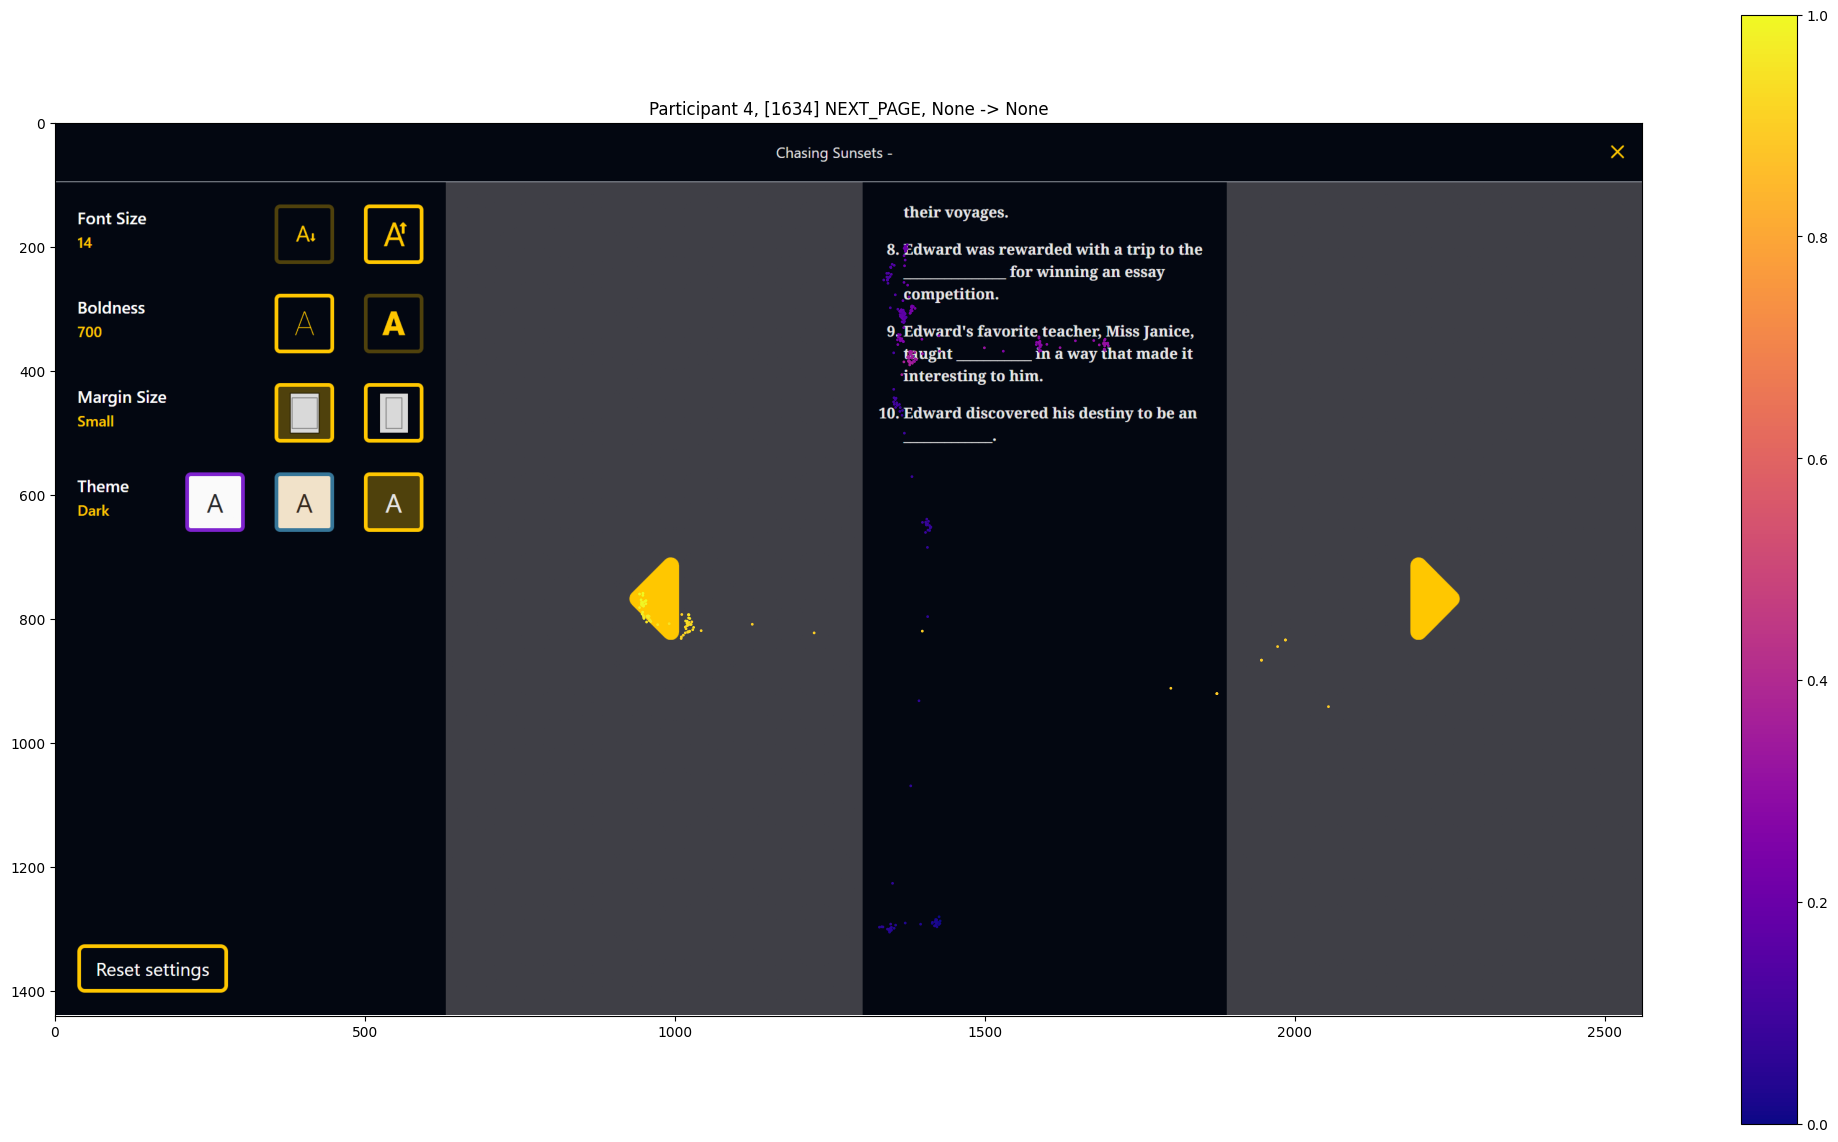

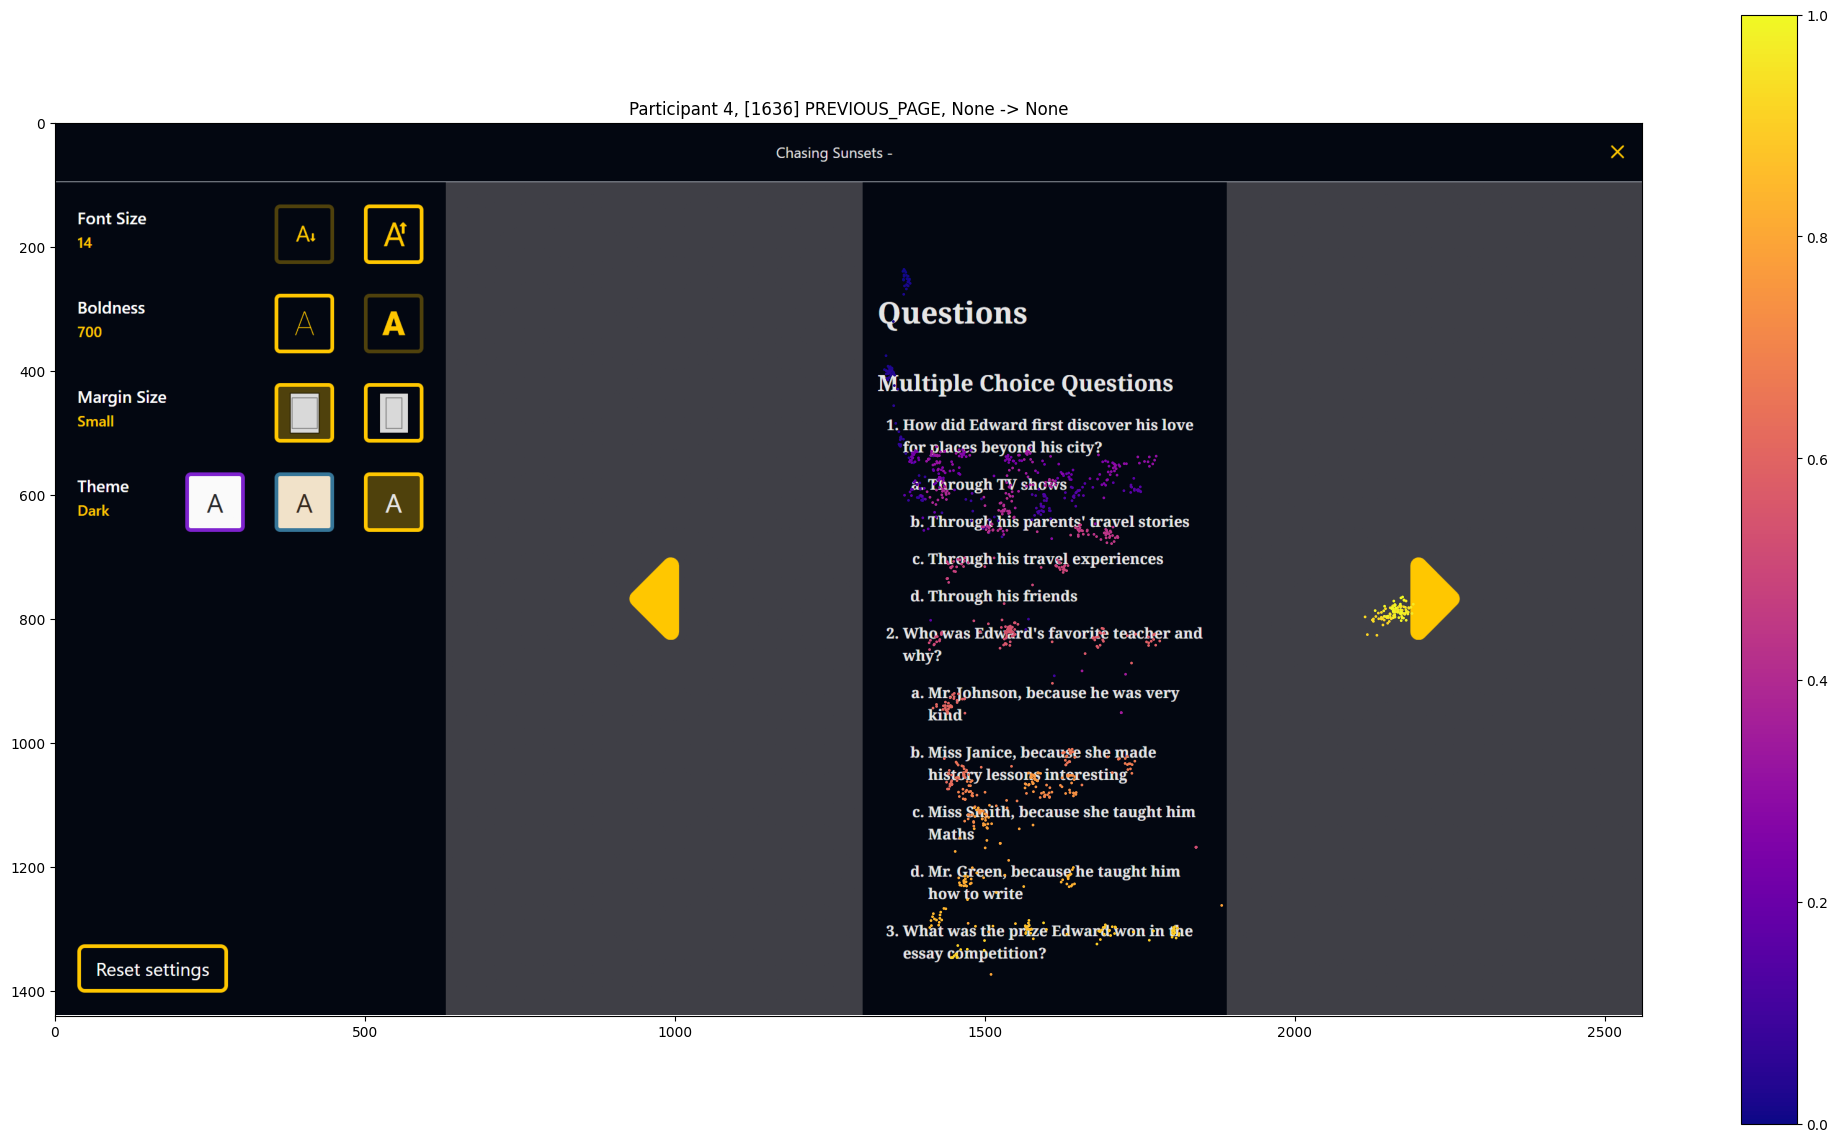

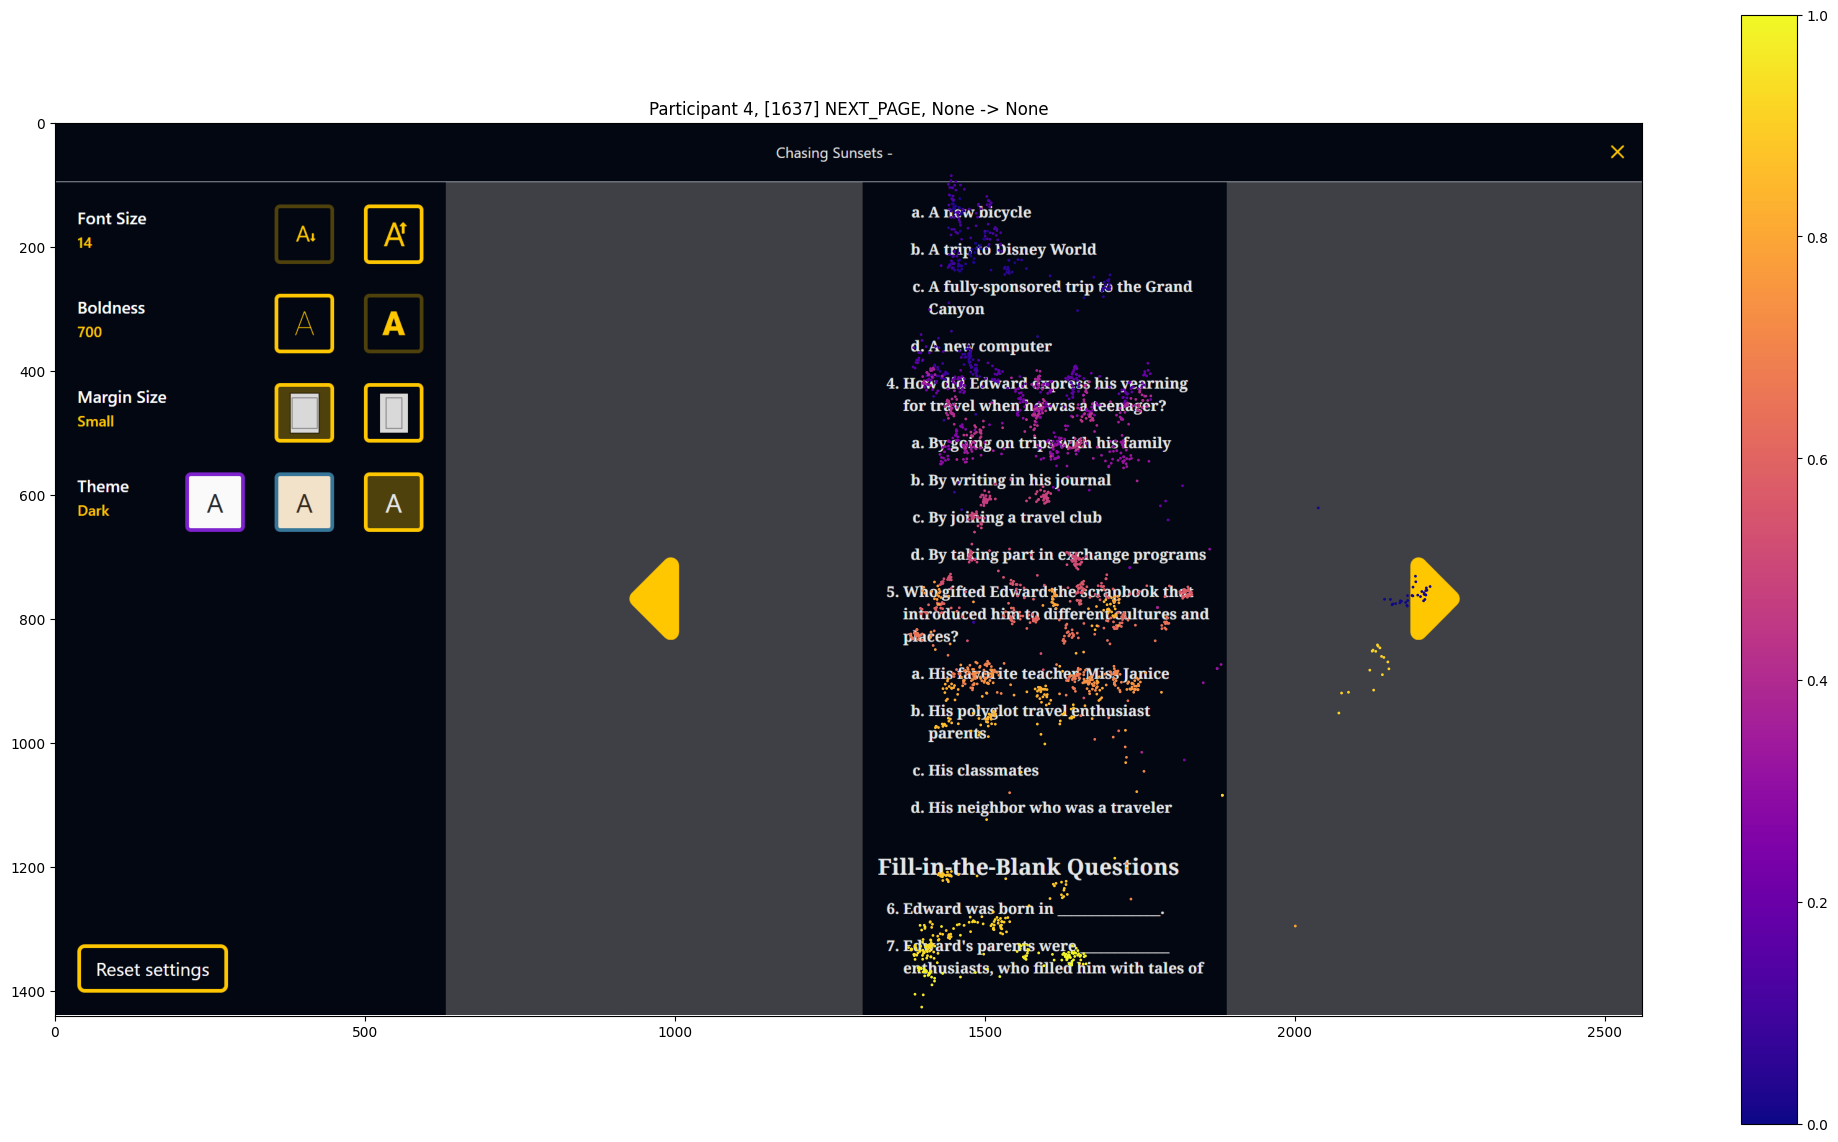

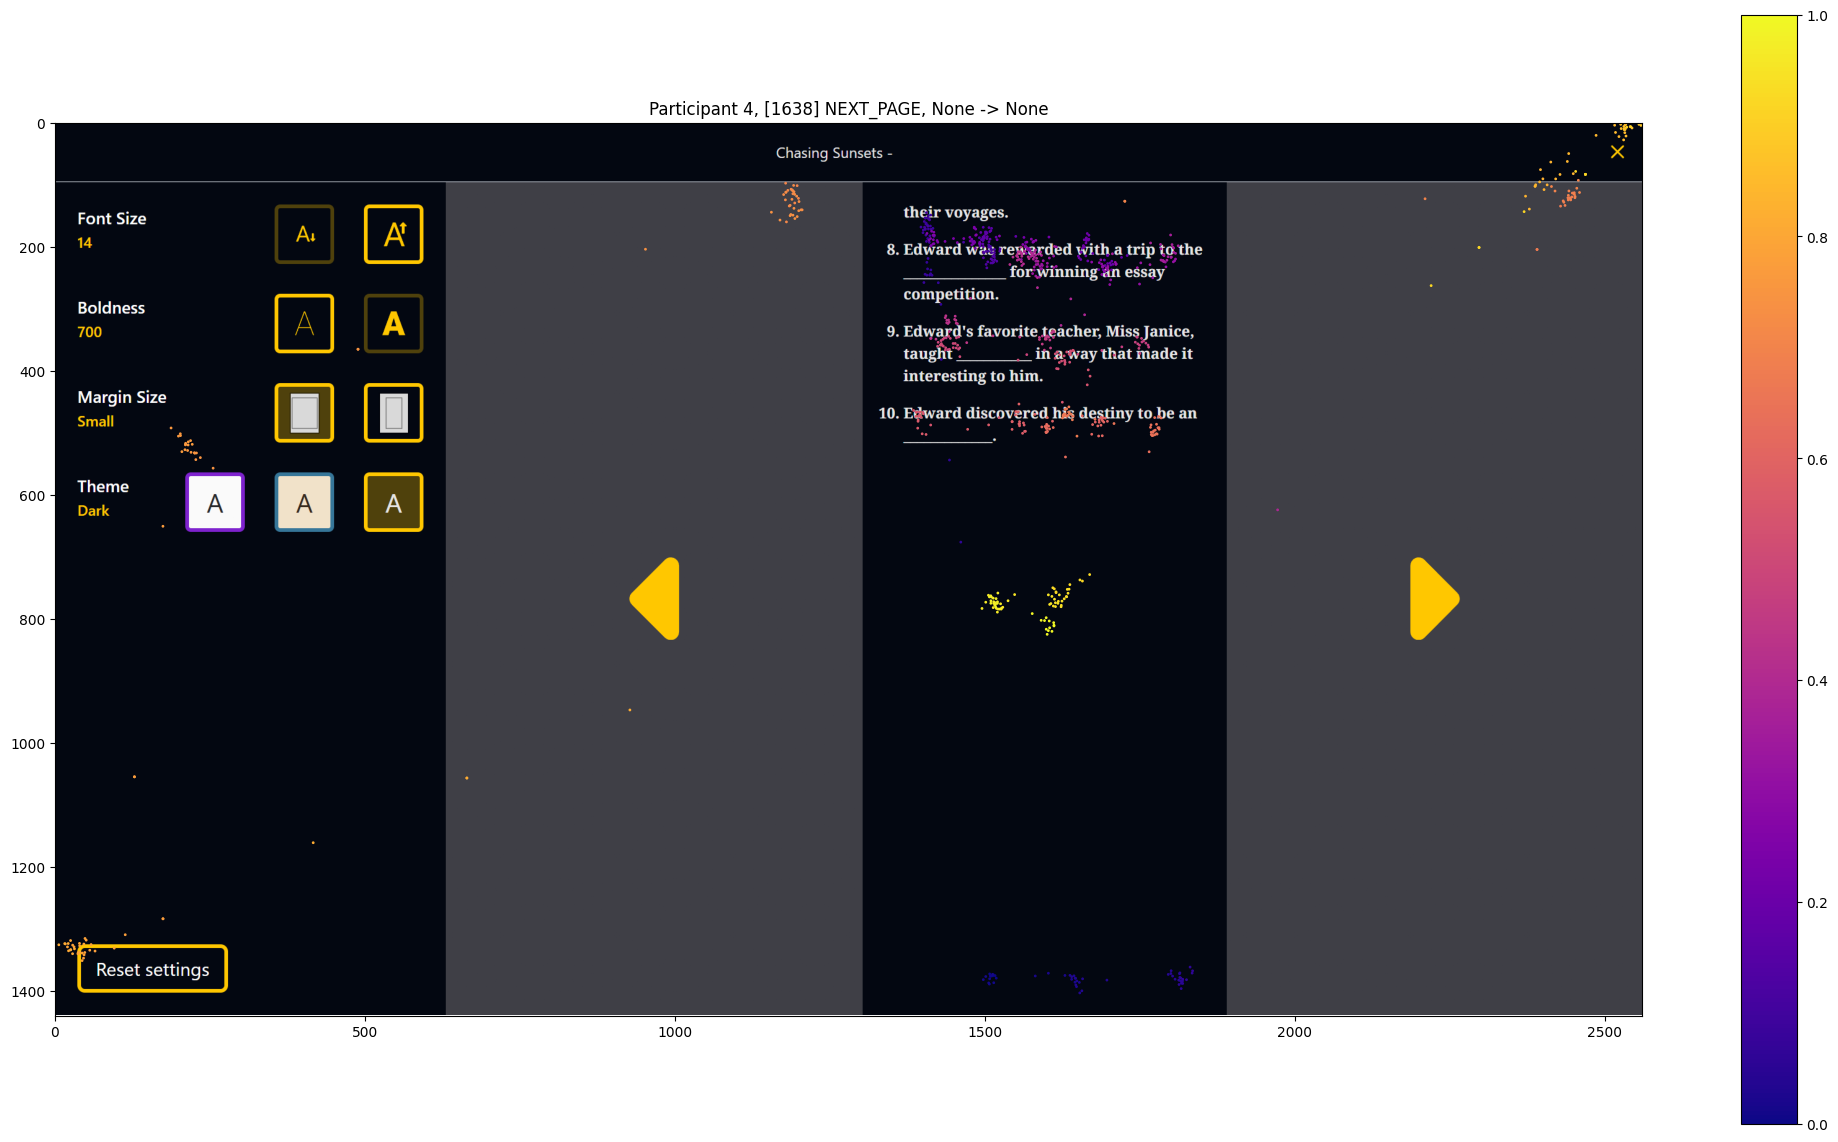

In [8]:
import os
from datetime import datetime

from utils import extract_gaze_data_between_timestamps_proper, plot_gaze_data_on_screenshot, print_record

# participants that were told that they can change the settings beforehand
participant_ids = [4]

# get the events
for participant in participant_ids:
  events = Events.select().where(Events.participant_id==participant)

  current_json_file = None
  batches_of_events = {}
  current_batch = []
  for event in events:
    if event.event == "SELECT_TREATMENT":
      continue
    elif event.event == "CLOSE_BOOK":
      current_batch.append(event)
      batches_of_events[current_json_file] = current_batch
      current_batch = []
    elif event.event == "OPEN_BOOK":
      timestamp = event.time
      date = datetime.fromtimestamp(timestamp / 1000)
      date_string = date.strftime("%Y-%m-%d_%H-%M-%S")
      current_json_file = f"[{participant}]-{date_string}.json"
      current_batch.append(event)
    else:
      current_batch.append(event)

  # for each json file, get the gaze data
  for json_file, events in batches_of_events.items():
    # get the gaze data for this participant
    # the files are in eye_tracker_data/
    path = "eye_tracker_data.combined/"

    # for start_event in events:
    gaze_data_filename = json_file
    gaze_data_filepath = os.path.join(path, gaze_data_filename)
    # Read the file
    import json
    with open(gaze_data_filepath, "r") as f:
      gaze_data = json.load(f)

    pairs = list(zip(events, events[1:]))
    for begin_page_event, end_page_event in pairs:
      T_start = begin_page_event.time
      T_end = end_page_event.time

      # ignore the event if the participant only looked at this page for less than 5 seconds
      if T_end - T_start < 1_000:
        continue

      gaze_data_between_pageturn_events = extract_gaze_data_between_timestamps_proper(gaze_data, T_start, T_end)['data']

      screenshot_path = begin_page_event.screenshot_file
      print_record(begin_page_event)
      plot_gaze_data_on_screenshot(gaze_data_between_pageturn_events, screenshot_path, title=f"Participant {participant}, [{begin_page_event.id}] {begin_page_event.event}, {begin_page_event.old_value} -> {begin_page_event.new_value}")


In [9]:
from utils import show_participant_screenshots


events = Events.select().where(Events.participant_id==999)
# show_participant_screenshots(events)